<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/VAE/VAE_08_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test VAE BCE

In [17]:
! pip install -q torchview --quiet
! pip install -q -U graphviz --quiet
!pip install torchviz --quiet

# path = "./ScatterPlots"
# if not os.path.exists(path): os.mkdir(path)

In [18]:
from torchview import draw_graph
import torch
import graphviz
from __future__ import print_function
import argparse
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.distributions as td
from torch.distributions import Categorical, Normal, Bernoulli
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchviz
import os
# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

In [ ]:
batch_size = 128
device = 'cuda'
kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data',
    train=True, download=True, transform=transforms.ToTensor()),
                 batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [68]:
class VAE(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=20, hid_1=400):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(in_dim, hid_1)
        self.fc21 = nn.Linear(hid_1, hidden_dim)
        self.fc22 = nn.Linear(hid_1, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hid_1)
        self.fc4 = nn.Linear(hid_1, out_dim)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    def reparameterize(self, mu, logvar):
        std = logvar.exp().pow(0.5)
        eps = torch.randn_like(std)
        # eps * std is element wise multiplication between vectors
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,self.in_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

model = VAE(784, 784).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.cuda(),
                                 x.view(-1, 784).cuda(),
                                 reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

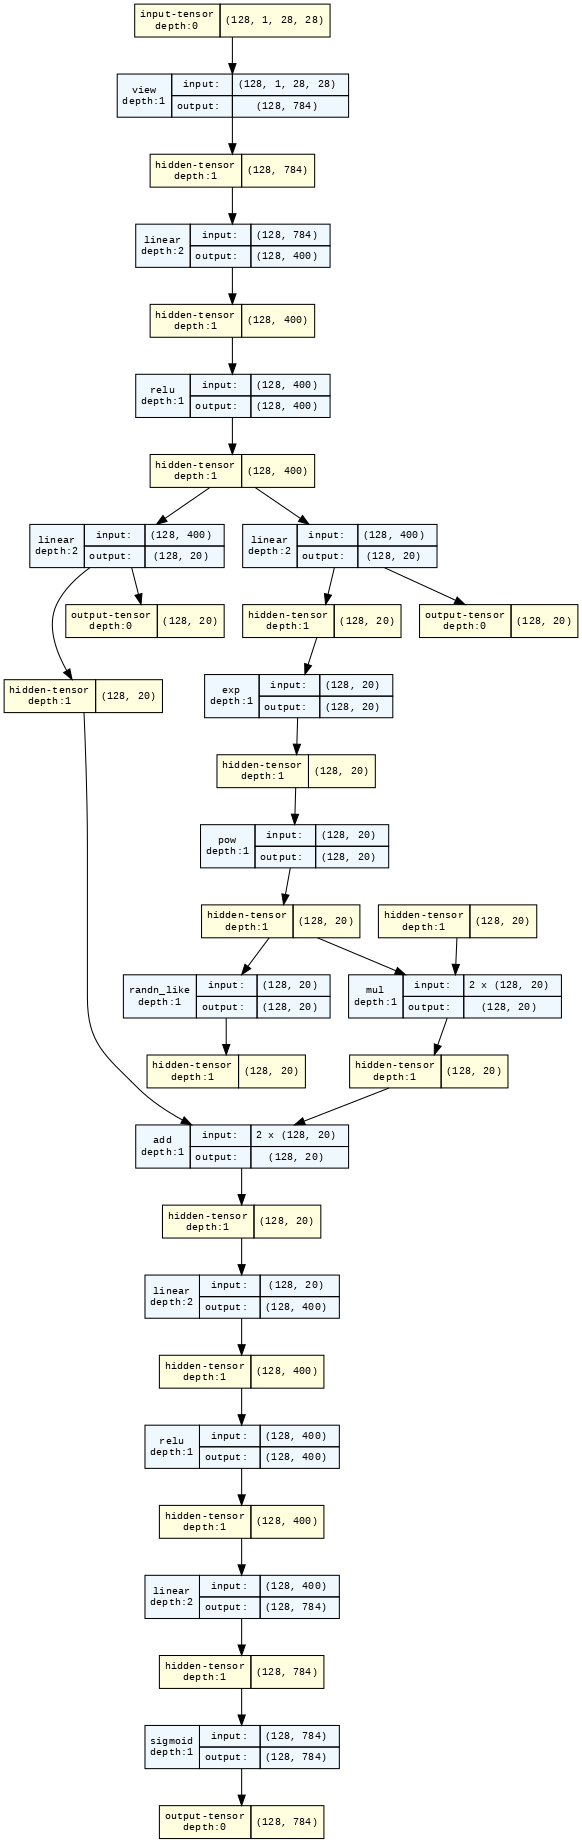

In [19]:
model_graph_1 = draw_graph(
    model, input_size=(batch_size, 1, 28, 28),
    graph_name='MLP',
    hide_inner_tensors=False,
    hide_module_functions=False,
)
model_graph_1.visual_graph

In [54]:

def train(epoch, log_interval=100):
    model.train()
    train_loss = 0
    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader),
                loss.item() / len(data)))
    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, label) in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                       recon_batch.view(-1, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                        'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss
import os
def create_path(path):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    #printing if the path exists or not
    print(path, ' folder is in directory: ', isExist)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path)
        print(path, " is created!")
create_path('results/')

results/  folder is in directory:  True


Train Epoch: 1 [0/60000 (0%)]	Loss: 101.877533
Train Epoch: 1 [25600/60000 (43%)]	Loss: 101.588699
Train Epoch: 1 [51200/60000 (85%)]	Loss: 105.650055
====> Epoch: 1 Average loss: 104.1474
====> Test set loss: 103.7612
Train Epoch: 2 [0/60000 (0%)]	Loss: 101.941704
Train Epoch: 2 [25600/60000 (43%)]	Loss: 106.814789
Train Epoch: 2 [51200/60000 (85%)]	Loss: 106.143814
====> Epoch: 2 Average loss: 103.9888
====> Test set loss: 103.8315
Train Epoch: 3 [0/60000 (0%)]	Loss: 101.566681
Train Epoch: 3 [25600/60000 (43%)]	Loss: 104.382019
Train Epoch: 3 [51200/60000 (85%)]	Loss: 100.578011
====> Epoch: 3 Average loss: 103.8457
====> Test set loss: 103.6798
Train Epoch: 4 [0/60000 (0%)]	Loss: 103.830353
Train Epoch: 4 [25600/60000 (43%)]	Loss: 100.792229
Train Epoch: 4 [51200/60000 (85%)]	Loss: 102.656677
====> Epoch: 4 Average loss: 103.7272
====> Test set loss: 103.7493
Train Epoch: 5 [0/60000 (0%)]	Loss: 106.193993
Train Epoch: 5 [25600/60000 (43%)]	Loss: 103.799759
Train Epoch: 5 [51200/600

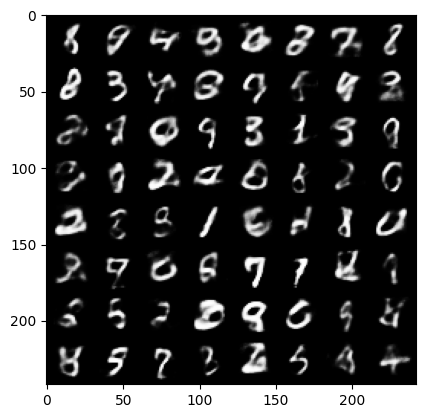

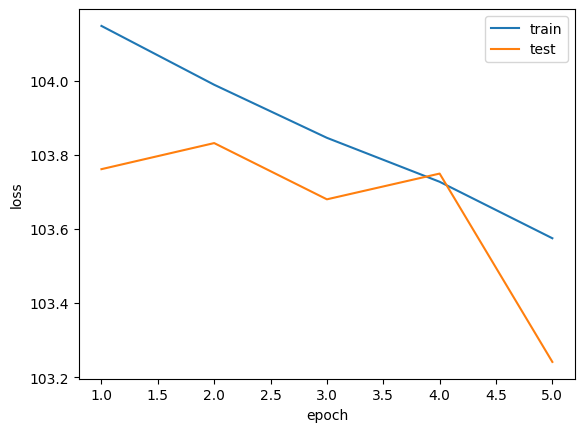

Train Epoch: 6 [0/60000 (0%)]	Loss: 103.604187
Train Epoch: 6 [25600/60000 (43%)]	Loss: 103.676674
Train Epoch: 6 [51200/60000 (85%)]	Loss: 106.629250
====> Epoch: 6 Average loss: 103.5299
====> Test set loss: 103.4112
Train Epoch: 7 [0/60000 (0%)]	Loss: 103.949158
Train Epoch: 7 [25600/60000 (43%)]	Loss: 101.147575
Train Epoch: 7 [51200/60000 (85%)]	Loss: 104.956322
====> Epoch: 7 Average loss: 103.3569
====> Test set loss: 103.3436
Train Epoch: 8 [0/60000 (0%)]	Loss: 107.190353
Train Epoch: 8 [25600/60000 (43%)]	Loss: 102.065788
Train Epoch: 8 [51200/60000 (85%)]	Loss: 101.720901
====> Epoch: 8 Average loss: 103.2803
====> Test set loss: 103.1634
Train Epoch: 9 [0/60000 (0%)]	Loss: 99.547913
Train Epoch: 9 [25600/60000 (43%)]	Loss: 101.396347
Train Epoch: 9 [51200/60000 (85%)]	Loss: 101.593498
====> Epoch: 9 Average loss: 103.1670
====> Test set loss: 103.1223
Train Epoch: 10 [0/60000 (0%)]	Loss: 103.480568
Train Epoch: 10 [25600/60000 (43%)]	Loss: 102.897034
Train Epoch: 10 [51200/6

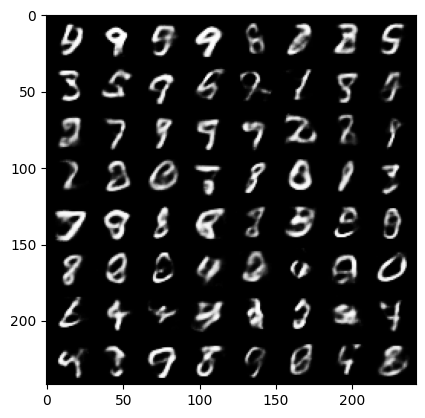

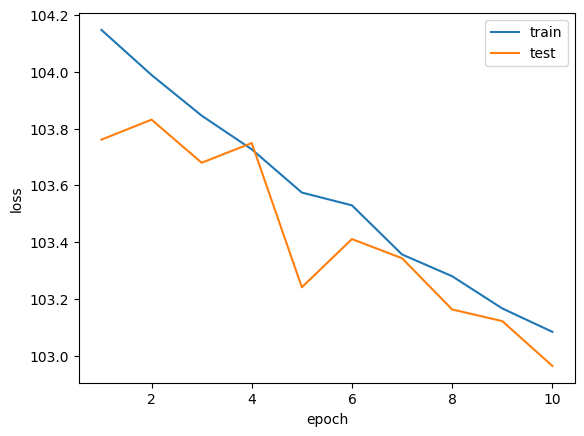

Train Epoch: 11 [0/60000 (0%)]	Loss: 106.624176
Train Epoch: 11 [25600/60000 (43%)]	Loss: 100.882156
Train Epoch: 11 [51200/60000 (85%)]	Loss: 103.873787
====> Epoch: 11 Average loss: 102.9891
====> Test set loss: 103.0249
Train Epoch: 12 [0/60000 (0%)]	Loss: 104.070724
Train Epoch: 12 [25600/60000 (43%)]	Loss: 100.795990
Train Epoch: 12 [51200/60000 (85%)]	Loss: 101.512634
====> Epoch: 12 Average loss: 102.8592
====> Test set loss: 103.0851
Train Epoch: 13 [0/60000 (0%)]	Loss: 105.225380
Train Epoch: 13 [25600/60000 (43%)]	Loss: 103.919739
Train Epoch: 13 [51200/60000 (85%)]	Loss: 102.422806
====> Epoch: 13 Average loss: 102.8223
====> Test set loss: 102.7639
Train Epoch: 14 [0/60000 (0%)]	Loss: 100.683983
Train Epoch: 14 [25600/60000 (43%)]	Loss: 102.974747
Train Epoch: 14 [51200/60000 (85%)]	Loss: 100.776627
====> Epoch: 14 Average loss: 102.7359
====> Test set loss: 103.0580
Train Epoch: 15 [0/60000 (0%)]	Loss: 99.648636
Train Epoch: 15 [25600/60000 (43%)]	Loss: 100.557167
Train Ep

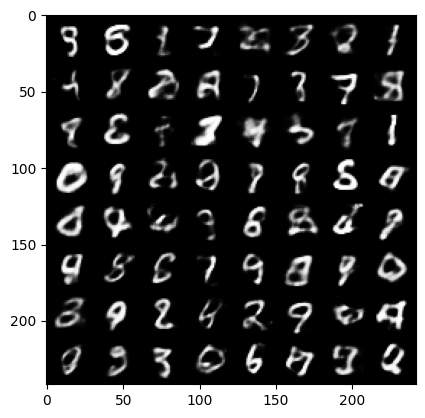

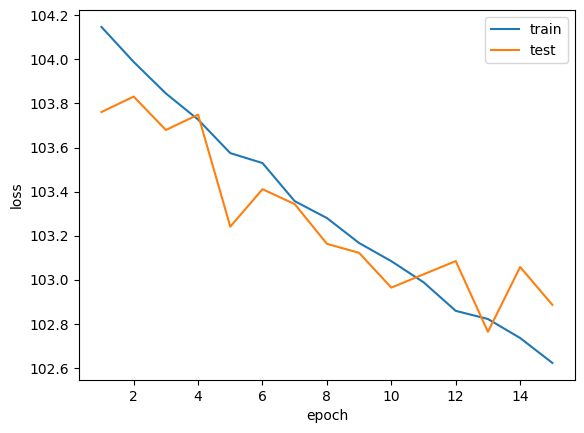

Train Epoch: 16 [0/60000 (0%)]	Loss: 100.167747
Train Epoch: 16 [25600/60000 (43%)]	Loss: 100.986069
Train Epoch: 16 [51200/60000 (85%)]	Loss: 101.122177
====> Epoch: 16 Average loss: 102.6199
====> Test set loss: 102.6782
Train Epoch: 17 [0/60000 (0%)]	Loss: 105.594757
Train Epoch: 17 [25600/60000 (43%)]	Loss: 104.380783
Train Epoch: 17 [51200/60000 (85%)]	Loss: 103.186874
====> Epoch: 17 Average loss: 102.5432
====> Test set loss: 102.6835
Train Epoch: 18 [0/60000 (0%)]	Loss: 103.538033
Train Epoch: 18 [25600/60000 (43%)]	Loss: 99.282524
Train Epoch: 18 [51200/60000 (85%)]	Loss: 102.275185
====> Epoch: 18 Average loss: 102.4553
====> Test set loss: 102.5617
Train Epoch: 19 [0/60000 (0%)]	Loss: 106.878418
Train Epoch: 19 [25600/60000 (43%)]	Loss: 104.204735
Train Epoch: 19 [51200/60000 (85%)]	Loss: 105.445145
====> Epoch: 19 Average loss: 102.3635
====> Test set loss: 102.5509
Train Epoch: 20 [0/60000 (0%)]	Loss: 102.813255
Train Epoch: 20 [25600/60000 (43%)]	Loss: 98.556084
Train Epo

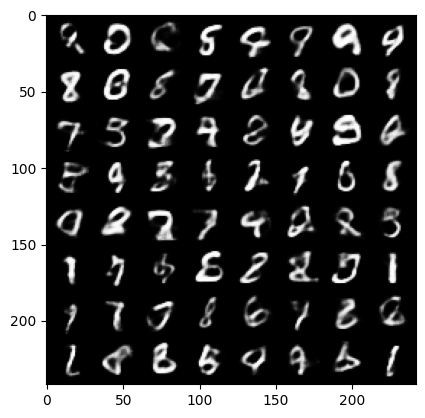

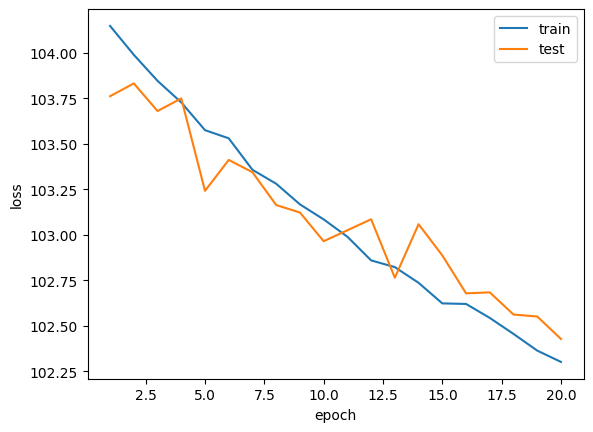

Train Epoch: 21 [0/60000 (0%)]	Loss: 101.741501
Train Epoch: 21 [25600/60000 (43%)]	Loss: 104.051071
Train Epoch: 21 [51200/60000 (85%)]	Loss: 101.282059
====> Epoch: 21 Average loss: 102.2516
====> Test set loss: 102.3669
Train Epoch: 22 [0/60000 (0%)]	Loss: 100.600479
Train Epoch: 22 [25600/60000 (43%)]	Loss: 99.570808
Train Epoch: 22 [51200/60000 (85%)]	Loss: 102.003548
====> Epoch: 22 Average loss: 102.1613
====> Test set loss: 102.1727
Train Epoch: 23 [0/60000 (0%)]	Loss: 99.147568
Train Epoch: 23 [25600/60000 (43%)]	Loss: 104.944687
Train Epoch: 23 [51200/60000 (85%)]	Loss: 100.532852
====> Epoch: 23 Average loss: 102.1528
====> Test set loss: 102.3531
Train Epoch: 24 [0/60000 (0%)]	Loss: 104.233719
Train Epoch: 24 [25600/60000 (43%)]	Loss: 105.504425
Train Epoch: 24 [51200/60000 (85%)]	Loss: 100.589111
====> Epoch: 24 Average loss: 102.0753
====> Test set loss: 102.1920
Train Epoch: 25 [0/60000 (0%)]	Loss: 98.815536
Train Epoch: 25 [25600/60000 (43%)]	Loss: 99.577621
Train Epoch

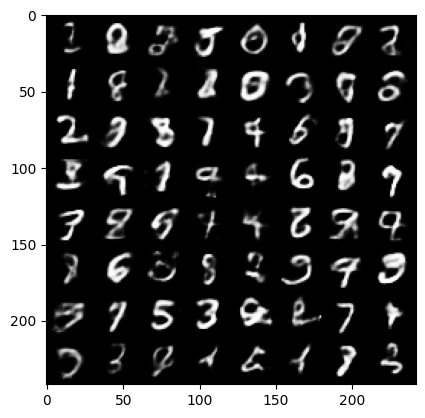

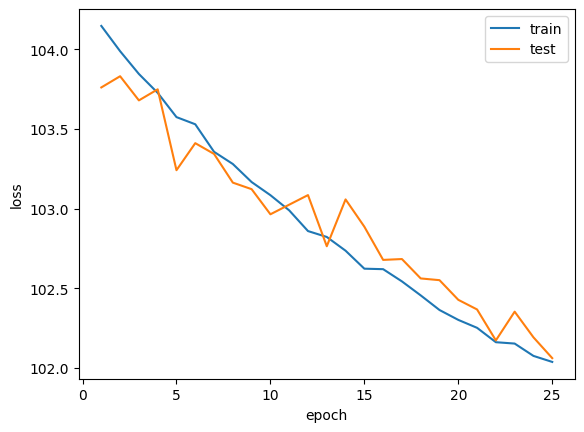

Train Epoch: 26 [0/60000 (0%)]	Loss: 104.801575
Train Epoch: 26 [25600/60000 (43%)]	Loss: 97.757339
Train Epoch: 26 [51200/60000 (85%)]	Loss: 104.590309
====> Epoch: 26 Average loss: 101.9934
====> Test set loss: 101.9746
Train Epoch: 27 [0/60000 (0%)]	Loss: 97.322319
Train Epoch: 27 [25600/60000 (43%)]	Loss: 103.192932
Train Epoch: 27 [51200/60000 (85%)]	Loss: 101.300468
====> Epoch: 27 Average loss: 101.9403
====> Test set loss: 102.2189
Train Epoch: 28 [0/60000 (0%)]	Loss: 103.821739
Train Epoch: 28 [25600/60000 (43%)]	Loss: 101.646057
Train Epoch: 28 [51200/60000 (85%)]	Loss: 98.862740
====> Epoch: 28 Average loss: 101.8942
====> Test set loss: 102.1911
Train Epoch: 29 [0/60000 (0%)]	Loss: 101.613411
Train Epoch: 29 [25600/60000 (43%)]	Loss: 102.777435
Train Epoch: 29 [51200/60000 (85%)]	Loss: 100.954636
====> Epoch: 29 Average loss: 101.8462
====> Test set loss: 102.0152
Train Epoch: 30 [0/60000 (0%)]	Loss: 100.605057
Train Epoch: 30 [25600/60000 (43%)]	Loss: 101.860779
Train Epoc

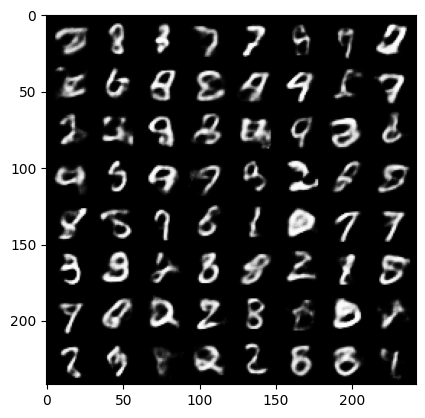

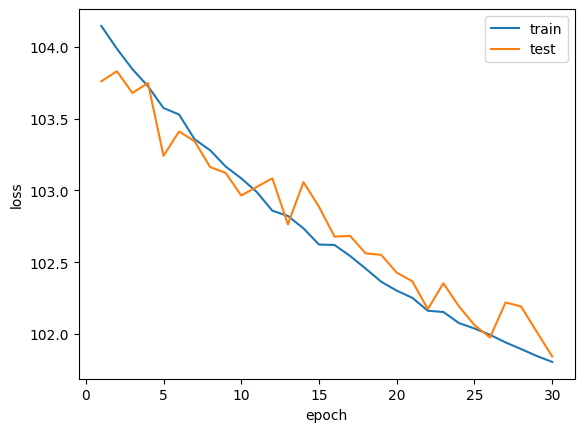

Train Epoch: 31 [0/60000 (0%)]	Loss: 102.197266
Train Epoch: 31 [25600/60000 (43%)]	Loss: 100.270828
Train Epoch: 31 [51200/60000 (85%)]	Loss: 103.551140
====> Epoch: 31 Average loss: 101.7592
====> Test set loss: 102.2365
Train Epoch: 32 [0/60000 (0%)]	Loss: 102.961578
Train Epoch: 32 [25600/60000 (43%)]	Loss: 100.555984
Train Epoch: 32 [51200/60000 (85%)]	Loss: 105.809830
====> Epoch: 32 Average loss: 101.6707
====> Test set loss: 101.8717
Train Epoch: 33 [0/60000 (0%)]	Loss: 107.142944
Train Epoch: 33 [25600/60000 (43%)]	Loss: 98.882645
Train Epoch: 33 [51200/60000 (85%)]	Loss: 102.146729
====> Epoch: 33 Average loss: 101.6548
====> Test set loss: 101.9382
Train Epoch: 34 [0/60000 (0%)]	Loss: 102.638184
Train Epoch: 34 [25600/60000 (43%)]	Loss: 103.975647
Train Epoch: 34 [51200/60000 (85%)]	Loss: 103.415192
====> Epoch: 34 Average loss: 101.6401
====> Test set loss: 101.7451
Train Epoch: 35 [0/60000 (0%)]	Loss: 99.748772
Train Epoch: 35 [25600/60000 (43%)]	Loss: 101.763451
Train Epo

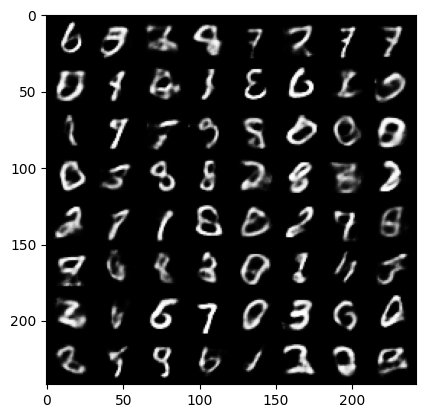

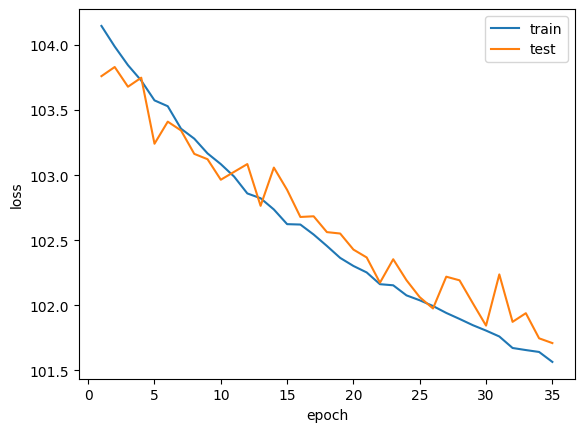

Train Epoch: 36 [0/60000 (0%)]	Loss: 103.007370
Train Epoch: 36 [25600/60000 (43%)]	Loss: 101.954819
Train Epoch: 36 [51200/60000 (85%)]	Loss: 100.884750
====> Epoch: 36 Average loss: 101.5105
====> Test set loss: 101.6906
Train Epoch: 37 [0/60000 (0%)]	Loss: 99.539230
Train Epoch: 37 [25600/60000 (43%)]	Loss: 102.128555
Train Epoch: 37 [51200/60000 (85%)]	Loss: 99.942780
====> Epoch: 37 Average loss: 101.5146
====> Test set loss: 101.6083
Train Epoch: 38 [0/60000 (0%)]	Loss: 104.021545
Train Epoch: 38 [25600/60000 (43%)]	Loss: 96.158890
Train Epoch: 38 [51200/60000 (85%)]	Loss: 100.973946
====> Epoch: 38 Average loss: 101.4420
====> Test set loss: 101.6441
Train Epoch: 39 [0/60000 (0%)]	Loss: 103.707184
Train Epoch: 39 [25600/60000 (43%)]	Loss: 100.460815
Train Epoch: 39 [51200/60000 (85%)]	Loss: 103.650345
====> Epoch: 39 Average loss: 101.4532
====> Test set loss: 101.7664
Train Epoch: 40 [0/60000 (0%)]	Loss: 103.875931
Train Epoch: 40 [25600/60000 (43%)]	Loss: 102.251572
Train Epoc

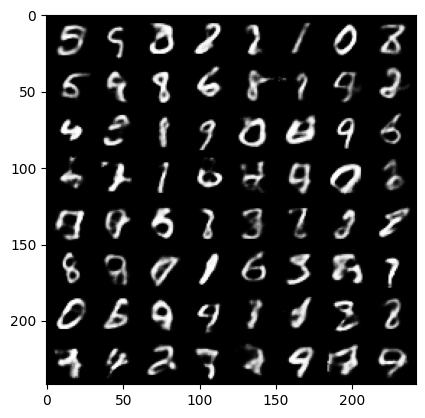

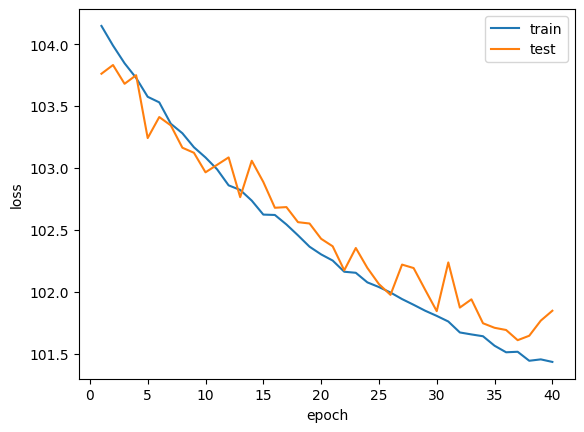

Train Epoch: 41 [0/60000 (0%)]	Loss: 100.623428
Train Epoch: 41 [25600/60000 (43%)]	Loss: 102.992363
Train Epoch: 41 [51200/60000 (85%)]	Loss: 103.701691
====> Epoch: 41 Average loss: 101.3442
====> Test set loss: 101.5801
Train Epoch: 42 [0/60000 (0%)]	Loss: 100.076736
Train Epoch: 42 [25600/60000 (43%)]	Loss: 105.517746
Train Epoch: 42 [51200/60000 (85%)]	Loss: 99.285294
====> Epoch: 42 Average loss: 101.3580
====> Test set loss: 101.5776
Train Epoch: 43 [0/60000 (0%)]	Loss: 98.802505
Train Epoch: 43 [25600/60000 (43%)]	Loss: 103.751297
Train Epoch: 43 [51200/60000 (85%)]	Loss: 102.042831
====> Epoch: 43 Average loss: 101.2812
====> Test set loss: 101.5883
Train Epoch: 44 [0/60000 (0%)]	Loss: 100.058273
Train Epoch: 44 [25600/60000 (43%)]	Loss: 102.527756
Train Epoch: 44 [51200/60000 (85%)]	Loss: 105.186325
====> Epoch: 44 Average loss: 101.2517
====> Test set loss: 101.3923
Train Epoch: 45 [0/60000 (0%)]	Loss: 96.826302
Train Epoch: 45 [25600/60000 (43%)]	Loss: 104.005760
Train Epoc

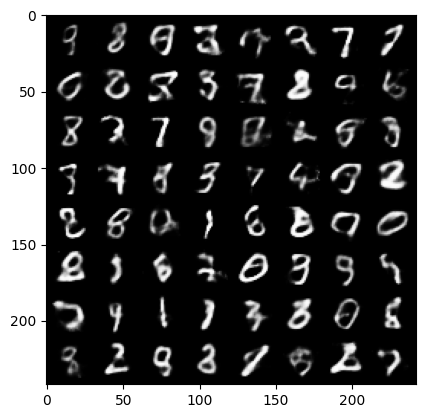

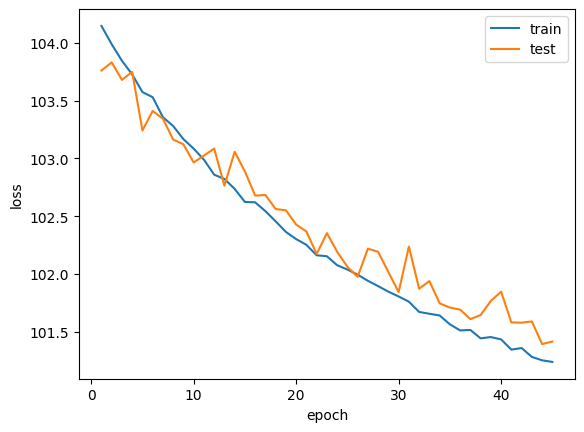

Train Epoch: 46 [0/60000 (0%)]	Loss: 101.287766
Train Epoch: 46 [25600/60000 (43%)]	Loss: 99.238548
Train Epoch: 46 [51200/60000 (85%)]	Loss: 99.171906
====> Epoch: 46 Average loss: 101.1796
====> Test set loss: 101.5134
Train Epoch: 47 [0/60000 (0%)]	Loss: 100.445801
Train Epoch: 47 [25600/60000 (43%)]	Loss: 101.800842
Train Epoch: 47 [51200/60000 (85%)]	Loss: 102.525436
====> Epoch: 47 Average loss: 101.1323
====> Test set loss: 101.4933
Train Epoch: 48 [0/60000 (0%)]	Loss: 104.102898
Train Epoch: 48 [25600/60000 (43%)]	Loss: 98.741165
Train Epoch: 48 [51200/60000 (85%)]	Loss: 99.953995
====> Epoch: 48 Average loss: 101.1531
====> Test set loss: 101.6813
Train Epoch: 49 [0/60000 (0%)]	Loss: 101.139023
Train Epoch: 49 [25600/60000 (43%)]	Loss: 104.118698
Train Epoch: 49 [51200/60000 (85%)]	Loss: 99.830826
====> Epoch: 49 Average loss: 101.0768
====> Test set loss: 101.4171
Train Epoch: 50 [0/60000 (0%)]	Loss: 103.996498
Train Epoch: 50 [25600/60000 (43%)]	Loss: 98.160141
Train Epoch: 

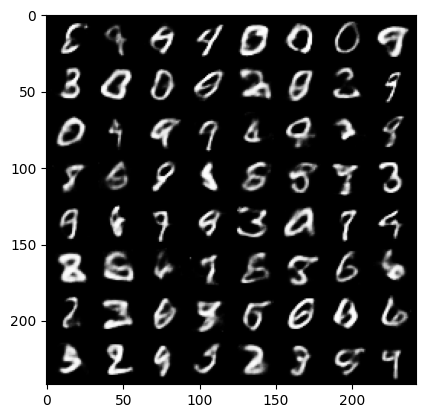

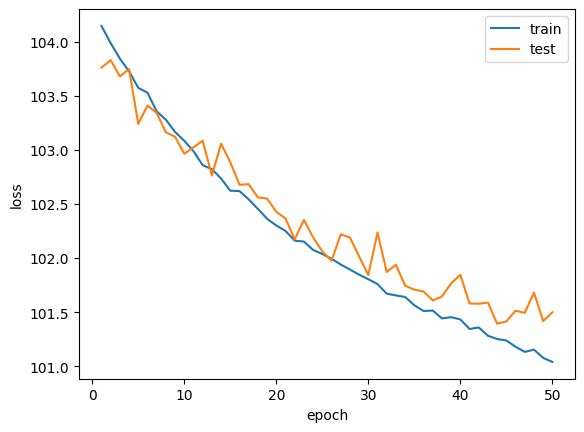

Train Epoch: 51 [0/60000 (0%)]	Loss: 100.483131
Train Epoch: 51 [25600/60000 (43%)]	Loss: 103.226898
Train Epoch: 51 [51200/60000 (85%)]	Loss: 99.792557
====> Epoch: 51 Average loss: 101.0173
====> Test set loss: 101.3148
Train Epoch: 52 [0/60000 (0%)]	Loss: 102.766411
Train Epoch: 52 [25600/60000 (43%)]	Loss: 102.270836
Train Epoch: 52 [51200/60000 (85%)]	Loss: 103.316414
====> Epoch: 52 Average loss: 100.9779
====> Test set loss: 101.4116
Train Epoch: 53 [0/60000 (0%)]	Loss: 97.597763
Train Epoch: 53 [25600/60000 (43%)]	Loss: 103.296448
Train Epoch: 53 [51200/60000 (85%)]	Loss: 101.301743
====> Epoch: 53 Average loss: 101.0078
====> Test set loss: 101.3846
Train Epoch: 54 [0/60000 (0%)]	Loss: 96.704430
Train Epoch: 54 [25600/60000 (43%)]	Loss: 99.683754
Train Epoch: 54 [51200/60000 (85%)]	Loss: 100.626289
====> Epoch: 54 Average loss: 100.9341
====> Test set loss: 101.2965
Train Epoch: 55 [0/60000 (0%)]	Loss: 102.041901
Train Epoch: 55 [25600/60000 (43%)]	Loss: 99.882133
Train Epoch:

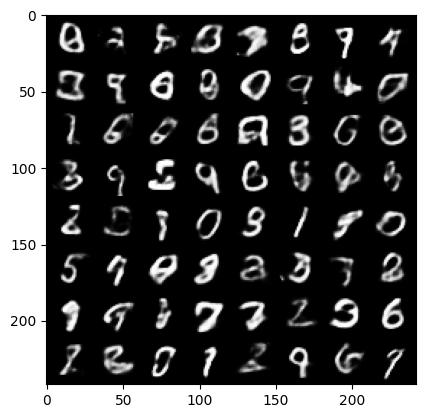

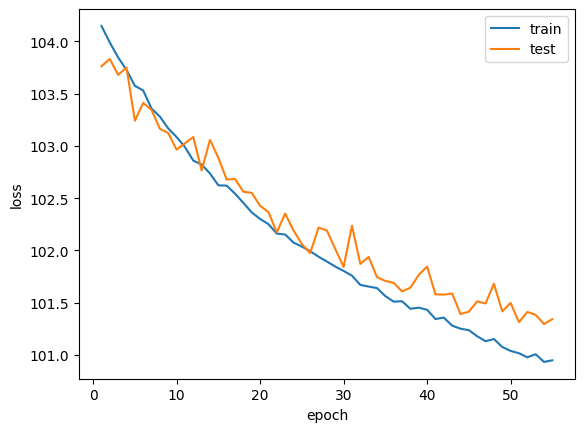

Train Epoch: 56 [0/60000 (0%)]	Loss: 96.231483
Train Epoch: 56 [25600/60000 (43%)]	Loss: 105.859375
Train Epoch: 56 [51200/60000 (85%)]	Loss: 101.179718
====> Epoch: 56 Average loss: 100.9410
====> Test set loss: 101.3896
Train Epoch: 57 [0/60000 (0%)]	Loss: 102.114243
Train Epoch: 57 [25600/60000 (43%)]	Loss: 104.642426
Train Epoch: 57 [51200/60000 (85%)]	Loss: 99.338638
====> Epoch: 57 Average loss: 100.9081
====> Test set loss: 101.2212
Train Epoch: 58 [0/60000 (0%)]	Loss: 101.953232
Train Epoch: 58 [25600/60000 (43%)]	Loss: 101.248726
Train Epoch: 58 [51200/60000 (85%)]	Loss: 101.333473
====> Epoch: 58 Average loss: 100.8690
====> Test set loss: 101.2818
Train Epoch: 59 [0/60000 (0%)]	Loss: 102.877045
Train Epoch: 59 [25600/60000 (43%)]	Loss: 103.998795
Train Epoch: 59 [51200/60000 (85%)]	Loss: 101.777603
====> Epoch: 59 Average loss: 100.8630
====> Test set loss: 101.2063
Train Epoch: 60 [0/60000 (0%)]	Loss: 98.867386
Train Epoch: 60 [25600/60000 (43%)]	Loss: 98.665901
Train Epoch

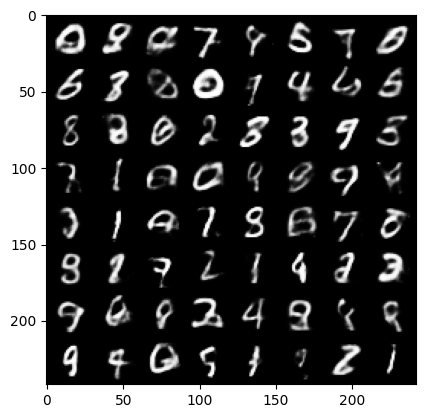

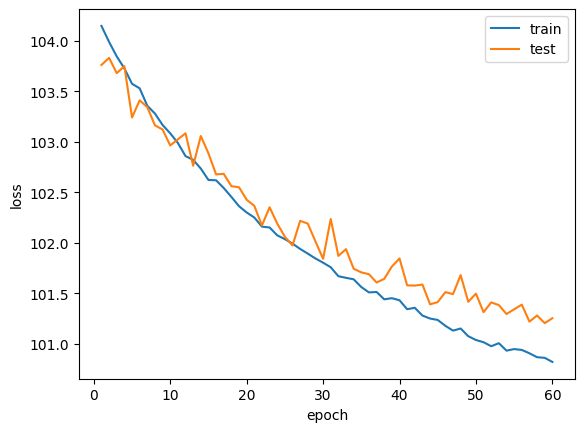

Train Epoch: 61 [0/60000 (0%)]	Loss: 97.715538
Train Epoch: 61 [25600/60000 (43%)]	Loss: 100.540588
Train Epoch: 61 [51200/60000 (85%)]	Loss: 100.898026
====> Epoch: 61 Average loss: 100.8071
====> Test set loss: 101.1941
Train Epoch: 62 [0/60000 (0%)]	Loss: 101.767960
Train Epoch: 62 [25600/60000 (43%)]	Loss: 101.050842
Train Epoch: 62 [51200/60000 (85%)]	Loss: 97.892677
====> Epoch: 62 Average loss: 100.7605
====> Test set loss: 101.3100
Train Epoch: 63 [0/60000 (0%)]	Loss: 99.660156
Train Epoch: 63 [25600/60000 (43%)]	Loss: 97.672958
Train Epoch: 63 [51200/60000 (85%)]	Loss: 102.336700
====> Epoch: 63 Average loss: 100.7564
====> Test set loss: 101.1735
Train Epoch: 64 [0/60000 (0%)]	Loss: 100.002884
Train Epoch: 64 [25600/60000 (43%)]	Loss: 102.510071
Train Epoch: 64 [51200/60000 (85%)]	Loss: 102.917587
====> Epoch: 64 Average loss: 100.7440
====> Test set loss: 101.0315
Train Epoch: 65 [0/60000 (0%)]	Loss: 100.720230
Train Epoch: 65 [25600/60000 (43%)]	Loss: 99.127167
Train Epoch:

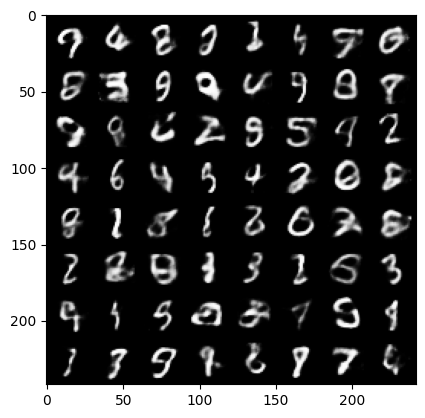

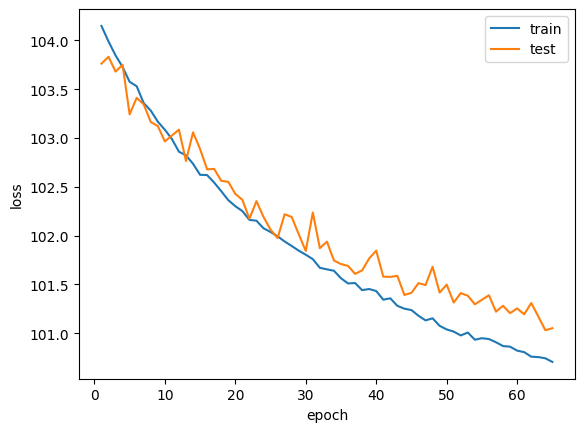

Train Epoch: 66 [0/60000 (0%)]	Loss: 99.553574
Train Epoch: 66 [25600/60000 (43%)]	Loss: 99.821869
Train Epoch: 66 [51200/60000 (85%)]	Loss: 102.323120
====> Epoch: 66 Average loss: 100.7000
====> Test set loss: 101.2417
Train Epoch: 67 [0/60000 (0%)]	Loss: 98.648956
Train Epoch: 67 [25600/60000 (43%)]	Loss: 98.420837
Train Epoch: 67 [51200/60000 (85%)]	Loss: 103.738541
====> Epoch: 67 Average loss: 100.6610
====> Test set loss: 100.9883
Train Epoch: 68 [0/60000 (0%)]	Loss: 105.522774
Train Epoch: 68 [25600/60000 (43%)]	Loss: 97.834732
Train Epoch: 68 [51200/60000 (85%)]	Loss: 99.051575
====> Epoch: 68 Average loss: 100.6383
====> Test set loss: 101.0520
Train Epoch: 69 [0/60000 (0%)]	Loss: 101.166992
Train Epoch: 69 [25600/60000 (43%)]	Loss: 103.077530
Train Epoch: 69 [51200/60000 (85%)]	Loss: 99.978226
====> Epoch: 69 Average loss: 100.6235
====> Test set loss: 101.3252
Train Epoch: 70 [0/60000 (0%)]	Loss: 104.303139
Train Epoch: 70 [25600/60000 (43%)]	Loss: 97.644760
Train Epoch: 70

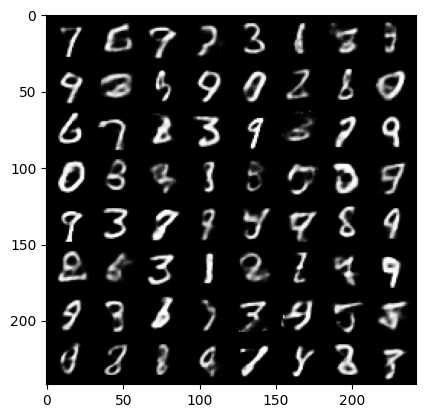

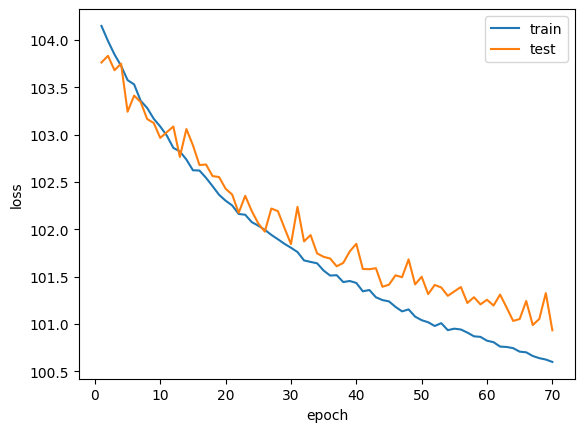

Train Epoch: 71 [0/60000 (0%)]	Loss: 95.466232
Train Epoch: 71 [25600/60000 (43%)]	Loss: 102.218864
Train Epoch: 71 [51200/60000 (85%)]	Loss: 100.856087
====> Epoch: 71 Average loss: 100.5686
====> Test set loss: 100.8414
Train Epoch: 72 [0/60000 (0%)]	Loss: 97.352020
Train Epoch: 72 [25600/60000 (43%)]	Loss: 102.467033
Train Epoch: 72 [51200/60000 (85%)]	Loss: 99.452354
====> Epoch: 72 Average loss: 100.5813
====> Test set loss: 101.0267
Train Epoch: 73 [0/60000 (0%)]	Loss: 97.120651
Train Epoch: 73 [25600/60000 (43%)]	Loss: 99.413811
Train Epoch: 73 [51200/60000 (85%)]	Loss: 97.421997
====> Epoch: 73 Average loss: 100.5442
====> Test set loss: 100.9188
Train Epoch: 74 [0/60000 (0%)]	Loss: 103.337219
Train Epoch: 74 [25600/60000 (43%)]	Loss: 107.017227
Train Epoch: 74 [51200/60000 (85%)]	Loss: 102.801125
====> Epoch: 74 Average loss: 100.5002
====> Test set loss: 100.9603
Train Epoch: 75 [0/60000 (0%)]	Loss: 94.947571
Train Epoch: 75 [25600/60000 (43%)]	Loss: 96.490540
Train Epoch: 75

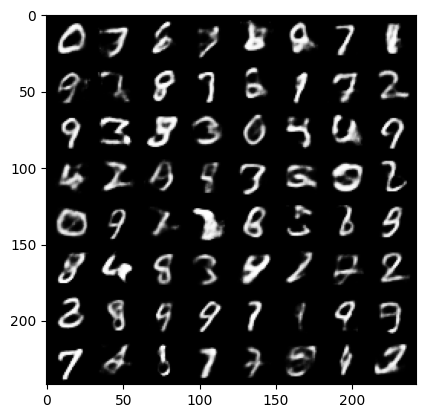

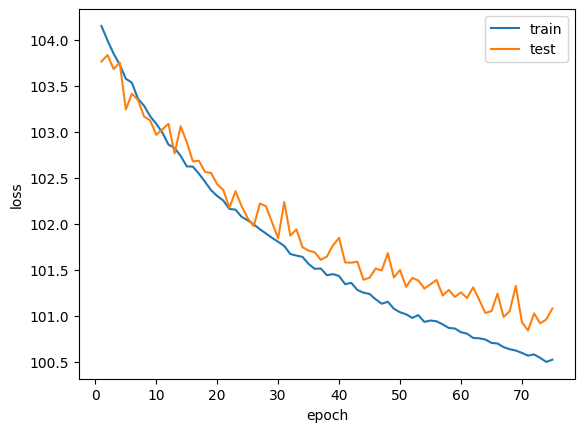

Train Epoch: 76 [0/60000 (0%)]	Loss: 101.136398
Train Epoch: 76 [25600/60000 (43%)]	Loss: 102.813614
Train Epoch: 76 [51200/60000 (85%)]	Loss: 100.531937
====> Epoch: 76 Average loss: 100.4352
====> Test set loss: 101.0319
Train Epoch: 77 [0/60000 (0%)]	Loss: 97.010300
Train Epoch: 77 [25600/60000 (43%)]	Loss: 102.902222
Train Epoch: 77 [51200/60000 (85%)]	Loss: 97.018158
====> Epoch: 77 Average loss: 100.4794
====> Test set loss: 100.8680
Train Epoch: 78 [0/60000 (0%)]	Loss: 94.665436
Train Epoch: 78 [25600/60000 (43%)]	Loss: 97.803970
Train Epoch: 78 [51200/60000 (85%)]	Loss: 99.530098
====> Epoch: 78 Average loss: 100.4281
====> Test set loss: 100.6069
Train Epoch: 79 [0/60000 (0%)]	Loss: 102.712967
Train Epoch: 79 [25600/60000 (43%)]	Loss: 97.797562
Train Epoch: 79 [51200/60000 (85%)]	Loss: 98.400848
====> Epoch: 79 Average loss: 100.4454
====> Test set loss: 100.9538
Train Epoch: 80 [0/60000 (0%)]	Loss: 96.550446
Train Epoch: 80 [25600/60000 (43%)]	Loss: 98.746643
Train Epoch: 80 

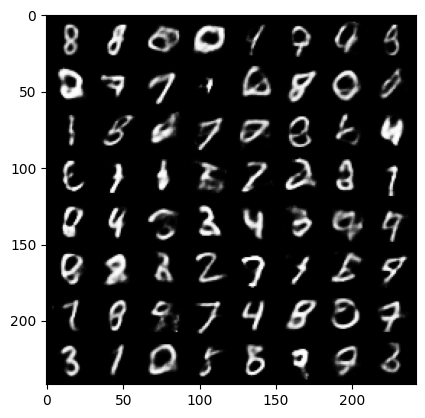

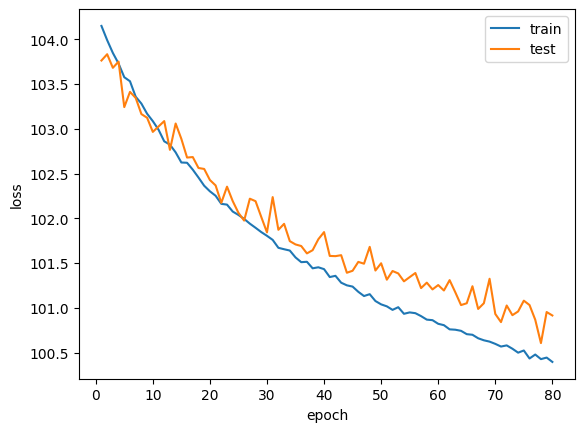

Train Epoch: 81 [0/60000 (0%)]	Loss: 99.771942
Train Epoch: 81 [25600/60000 (43%)]	Loss: 103.186241
Train Epoch: 81 [51200/60000 (85%)]	Loss: 100.900505
====> Epoch: 81 Average loss: 100.4181
====> Test set loss: 100.6540
Train Epoch: 82 [0/60000 (0%)]	Loss: 102.931129
Train Epoch: 82 [25600/60000 (43%)]	Loss: 105.379608
Train Epoch: 82 [51200/60000 (85%)]	Loss: 100.857452
====> Epoch: 82 Average loss: 100.3486
====> Test set loss: 101.1720
Train Epoch: 83 [0/60000 (0%)]	Loss: 99.744667
Train Epoch: 83 [25600/60000 (43%)]	Loss: 101.177917
Train Epoch: 83 [51200/60000 (85%)]	Loss: 98.779327
====> Epoch: 83 Average loss: 100.4097
====> Test set loss: 100.6799
Train Epoch: 84 [0/60000 (0%)]	Loss: 99.404572
Train Epoch: 84 [25600/60000 (43%)]	Loss: 98.247490
Train Epoch: 84 [51200/60000 (85%)]	Loss: 96.700684
====> Epoch: 84 Average loss: 100.3141
====> Test set loss: 100.7796
Train Epoch: 85 [0/60000 (0%)]	Loss: 99.372658
Train Epoch: 85 [25600/60000 (43%)]	Loss: 103.569366
Train Epoch: 8

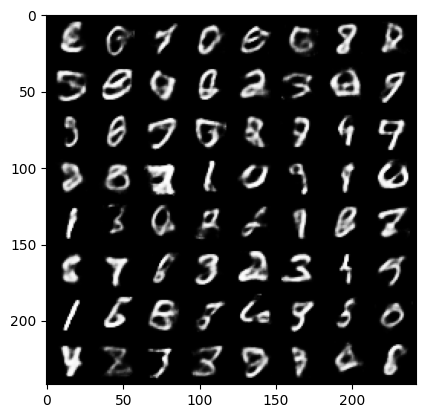

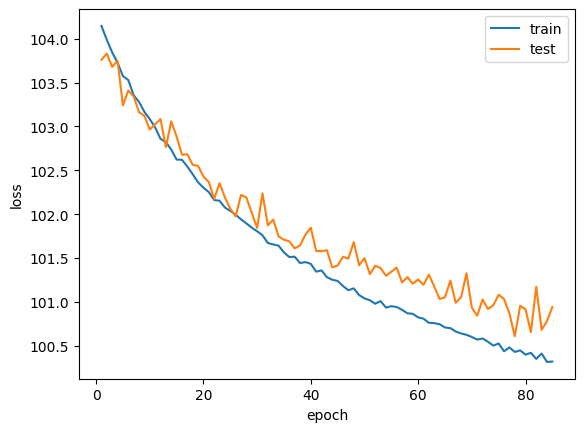

Train Epoch: 86 [0/60000 (0%)]	Loss: 98.768440
Train Epoch: 86 [25600/60000 (43%)]	Loss: 100.781189
Train Epoch: 86 [51200/60000 (85%)]	Loss: 101.182129
====> Epoch: 86 Average loss: 100.2997
====> Test set loss: 100.7884
Train Epoch: 87 [0/60000 (0%)]	Loss: 101.081398
Train Epoch: 87 [25600/60000 (43%)]	Loss: 100.514648
Train Epoch: 87 [51200/60000 (85%)]	Loss: 102.450821
====> Epoch: 87 Average loss: 100.2947
====> Test set loss: 100.7545
Train Epoch: 88 [0/60000 (0%)]	Loss: 102.050804
Train Epoch: 88 [25600/60000 (43%)]	Loss: 99.713821
Train Epoch: 88 [51200/60000 (85%)]	Loss: 101.189171
====> Epoch: 88 Average loss: 100.2657
====> Test set loss: 100.7422
Train Epoch: 89 [0/60000 (0%)]	Loss: 100.021347
Train Epoch: 89 [25600/60000 (43%)]	Loss: 98.874313
Train Epoch: 89 [51200/60000 (85%)]	Loss: 101.353653
====> Epoch: 89 Average loss: 100.2756
====> Test set loss: 100.6645
Train Epoch: 90 [0/60000 (0%)]	Loss: 97.061241
Train Epoch: 90 [25600/60000 (43%)]	Loss: 99.354630
Train Epoch:

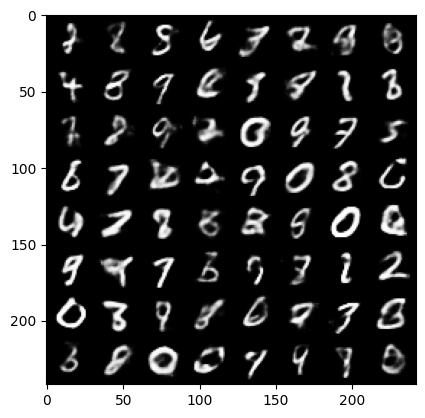

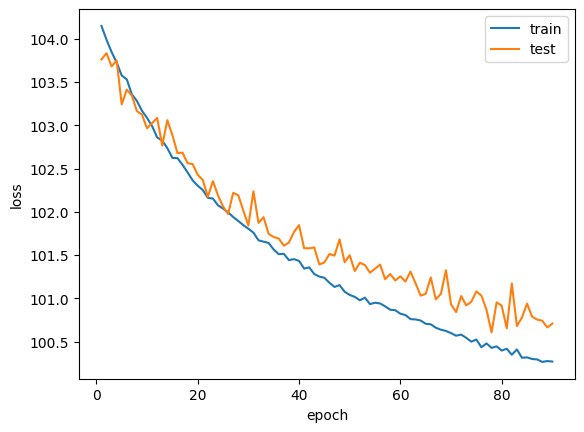

Train Epoch: 91 [0/60000 (0%)]	Loss: 95.848289
Train Epoch: 91 [25600/60000 (43%)]	Loss: 99.428452
Train Epoch: 91 [51200/60000 (85%)]	Loss: 99.598679
====> Epoch: 91 Average loss: 100.2254
====> Test set loss: 100.9183
Train Epoch: 92 [0/60000 (0%)]	Loss: 103.456146
Train Epoch: 92 [25600/60000 (43%)]	Loss: 98.448441
Train Epoch: 92 [51200/60000 (85%)]	Loss: 101.938675
====> Epoch: 92 Average loss: 100.2447
====> Test set loss: 100.8838
Train Epoch: 93 [0/60000 (0%)]	Loss: 100.081619
Train Epoch: 93 [25600/60000 (43%)]	Loss: 99.783081
Train Epoch: 93 [51200/60000 (85%)]	Loss: 101.619339
====> Epoch: 93 Average loss: 100.1802
====> Test set loss: 100.6795
Train Epoch: 94 [0/60000 (0%)]	Loss: 95.859673
Train Epoch: 94 [25600/60000 (43%)]	Loss: 102.109428
Train Epoch: 94 [51200/60000 (85%)]	Loss: 101.651230
====> Epoch: 94 Average loss: 100.2195
====> Test set loss: 100.6322
Train Epoch: 95 [0/60000 (0%)]	Loss: 98.726227
Train Epoch: 95 [25600/60000 (43%)]	Loss: 101.393921
Train Epoch: 9

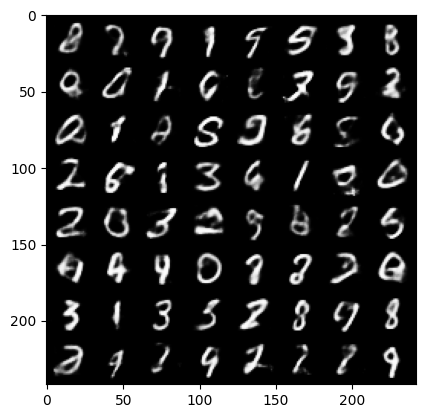

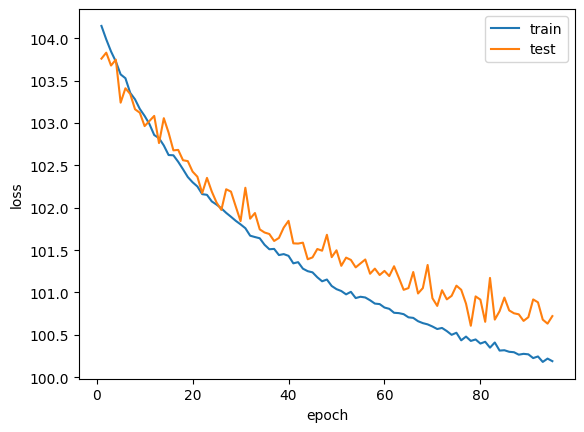

Train Epoch: 96 [0/60000 (0%)]	Loss: 102.592285
Train Epoch: 96 [25600/60000 (43%)]	Loss: 98.933319
Train Epoch: 96 [51200/60000 (85%)]	Loss: 100.008133
====> Epoch: 96 Average loss: 100.1867
====> Test set loss: 100.7019
Train Epoch: 97 [0/60000 (0%)]	Loss: 96.941246
Train Epoch: 97 [25600/60000 (43%)]	Loss: 99.728424
Train Epoch: 97 [51200/60000 (85%)]	Loss: 100.602379
====> Epoch: 97 Average loss: 100.1440
====> Test set loss: 100.8218
Train Epoch: 98 [0/60000 (0%)]	Loss: 99.333527
Train Epoch: 98 [25600/60000 (43%)]	Loss: 101.841476
Train Epoch: 98 [51200/60000 (85%)]	Loss: 97.447037
====> Epoch: 98 Average loss: 100.0823
====> Test set loss: 100.5443
Train Epoch: 99 [0/60000 (0%)]	Loss: 99.744659
Train Epoch: 99 [25600/60000 (43%)]	Loss: 100.245155
Train Epoch: 99 [51200/60000 (85%)]	Loss: 98.213181
====> Epoch: 99 Average loss: 100.1191
====> Test set loss: 100.5304
Train Epoch: 100 [0/60000 (0%)]	Loss: 100.671646
Train Epoch: 100 [25600/60000 (43%)]	Loss: 102.573273
Train Epoch:

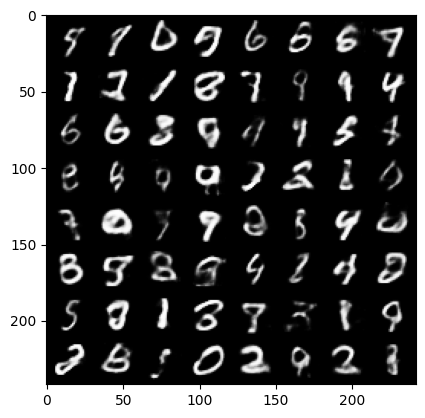

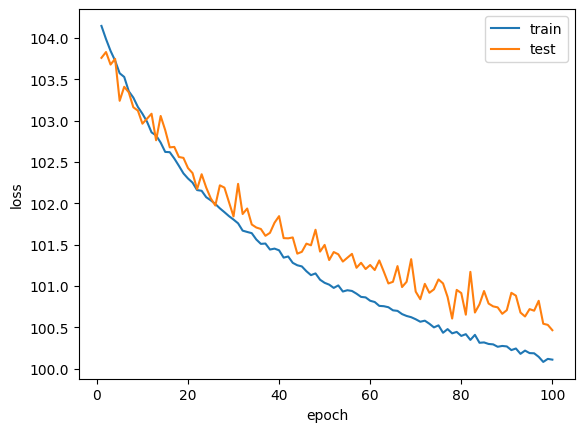

In [46]:
train_loss_list = []
test_loss_list = []
hidden_dim = 20
epochs = 100
# import matplotlib.image as img

# # reading png image file
# im = img.imread('results/reconstruction_'+str(1)+'.png')
# # show image
# plt.imshow(im)

for epoch in range(1, epochs+1):
    train_loss = train(epoch, 200)
    test_loss = test(epoch)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)


    with torch.no_grad():
        if epoch % 5 == 0:
            sample = torch.randn(64, hidden_dim).to(device)
            sample = model.decode(sample).cpu()
            save_img_name = 'results/sample_'+str(epoch)+'.png'
            save_image(sample.view(64, 1, 28, 28), save_img_name)
            print('*'* 20, f'epoch={epoch}', '*'* 20)
            plt.imshow(img.imread(save_img_name))
            assert len(train_loss_list) == len(test_loss_list)
            l = len(train_loss_list)
            # plot lines
            plt.figure()
            plt.plot(range(1, l+1), train_loss_list, label = "train")
            plt.plot(range(1, l+1), test_loss_list, label = "test")
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

In [63]:
class deepVAE(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=20,
                 hid_1=256*2, hid_2=256, hid_3=128):
        super(deepVAE, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(in_dim, hid_1)
        self.fc2 = nn.Linear(hid_1, hid_2)
        self.fc3 = nn.Linear(hid_2, hid_3)
        self.fc41 = nn.Linear(hid_3, hidden_dim)
        self.fc42 = nn.Linear(hid_3, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hid_3)
        self.fc6 = nn.Linear(hid_3, hid_2)
        self.fc7 = nn.Linear(hid_2, hid_1)
        self.fc8 = nn.Linear(hid_1, out_dim)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc2(h1))
        h1 = F.relu(self.fc3(h1))
        return self.fc41(h1), self.fc42(h1)
    def decode(self, z):
        h3 = F.relu(self.fc5(z))
        h3 = F.relu(self.fc6(h3))
        h3 = F.relu(self.fc7(h3))
        return torch.sigmoid(self.fc8(h3))
    def reparameterize(self, mu, logvar):
        std = logvar.exp().pow(0.5)
        eps = torch.randn_like(std)
        # eps * std is element wise multiplication between vectors
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,self.in_dim))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar



In [50]:
def plot_loss(train_list, test_list):
    assert len(train_list) == len(test_list)
    l = len(train_list)
    plt.figure()
    plt.plot(range(1, l+1), train_list, label = "train")
    plt.plot(range(1, l+1), test_list, label = "test")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [67]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
class MODEL:
    def __init__(self, model, loss_function=loss_function,
                 train_loader=train_loader, test_loader=test_loader,
                 optimizer=optimizer):
        super(MODEL, self).__init__()
        self.model = model
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer

    def get_model(self):
        return self.model

    def train(self, epoch, log_interval=100, print_info=True):
        self.model.train()
        train_loss = 0
        for i, (data, _) in enumerate(self.train_loader):
            data = data.to(device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if i % log_interval == 0 and print_info == True:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader),
                loss.item() / len(data)))
        train_loss /= len(train_loader.dataset)
        if print_info == True:
            print('====> Epoch: {} Average loss: {:.4f}'.format(
                                epoch, train_loss))
        return train_loss
    def test(self, epoch):
        self.model.eval()
        test_loss = 0
        for i, (data, _) in enumerate(self.test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = self.model(data)
            test_loss += self.loss_function(
                recon_batch, data, mu, logvar).item()
        test_loss /= len(self.test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        return test_loss



Train Epoch: 1 [0/60000 (0%)]	Loss: 543.910950
Train Epoch: 1 [25600/60000 (43%)]	Loss: 193.689987
Train Epoch: 1 [51200/60000 (85%)]	Loss: 167.350052
====> Epoch: 1 Average loss: 191.6676
====> Test set loss: 162.7332
Train Epoch: 2 [0/60000 (0%)]	Loss: 160.000366
Train Epoch: 2 [25600/60000 (43%)]	Loss: 147.817917
Train Epoch: 2 [51200/60000 (85%)]	Loss: 144.583206
====> Epoch: 2 Average loss: 149.3984
====> Test set loss: 139.6895
Train Epoch: 3 [0/60000 (0%)]	Loss: 145.616287
Train Epoch: 3 [25600/60000 (43%)]	Loss: 129.138947
Train Epoch: 3 [51200/60000 (85%)]	Loss: 133.623077
====> Epoch: 3 Average loss: 134.2761
====> Test set loss: 128.7517
Train Epoch: 4 [0/60000 (0%)]	Loss: 125.745285
Train Epoch: 4 [25600/60000 (43%)]	Loss: 125.699760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 127.590515
====> Epoch: 4 Average loss: 125.7807
====> Test set loss: 122.7432
Train Epoch: 5 [0/60000 (0%)]	Loss: 125.686951
Train Epoch: 5 [25600/60000 (43%)]	Loss: 119.090172
Train Epoch: 5 [51200/600

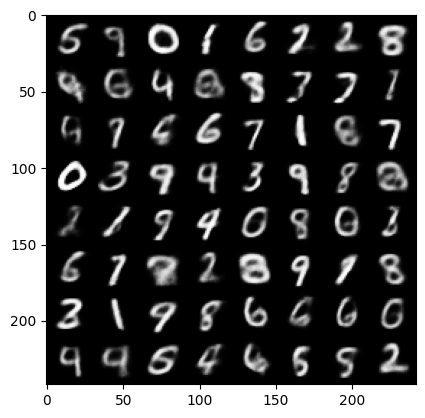

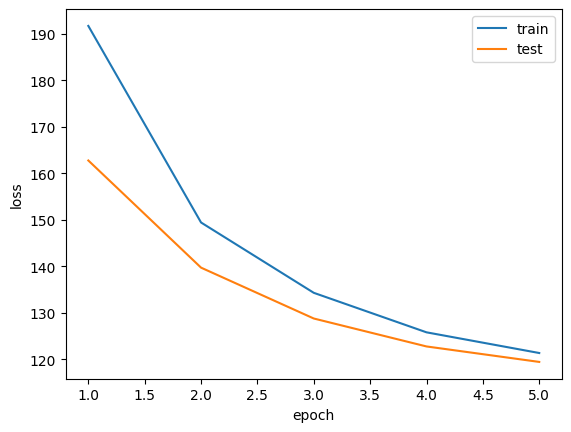

Train Epoch: 6 [0/60000 (0%)]	Loss: 119.693253
Train Epoch: 6 [25600/60000 (43%)]	Loss: 121.472542
Train Epoch: 6 [51200/60000 (85%)]	Loss: 120.582596
====> Epoch: 6 Average loss: 118.7465
====> Test set loss: 117.6987
Train Epoch: 7 [0/60000 (0%)]	Loss: 119.215553
Train Epoch: 7 [25600/60000 (43%)]	Loss: 114.272835
Train Epoch: 7 [51200/60000 (85%)]	Loss: 119.777588
====> Epoch: 7 Average loss: 116.9378
====> Test set loss: 116.0073
Train Epoch: 8 [0/60000 (0%)]	Loss: 122.467636
Train Epoch: 8 [25600/60000 (43%)]	Loss: 116.295288
Train Epoch: 8 [51200/60000 (85%)]	Loss: 117.037575
====> Epoch: 8 Average loss: 115.6119
====> Test set loss: 115.0914
Train Epoch: 9 [0/60000 (0%)]	Loss: 114.867653
Train Epoch: 9 [25600/60000 (43%)]	Loss: 113.239761
Train Epoch: 9 [51200/60000 (85%)]	Loss: 113.340401
====> Epoch: 9 Average loss: 114.4735
====> Test set loss: 114.3000
Train Epoch: 10 [0/60000 (0%)]	Loss: 116.994644
Train Epoch: 10 [25600/60000 (43%)]	Loss: 109.302666
Train Epoch: 10 [51200/

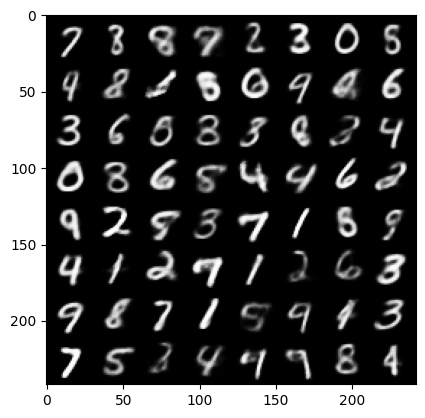

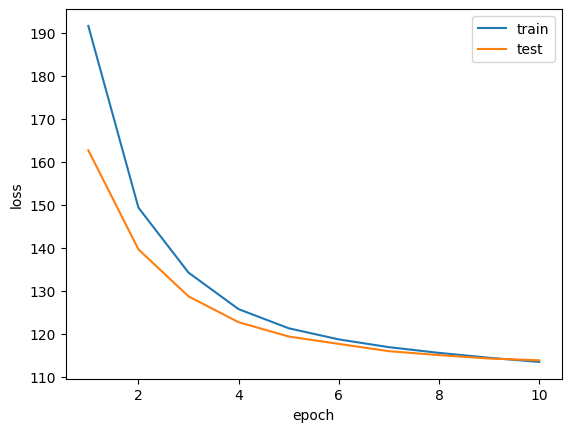

Train Epoch: 11 [0/60000 (0%)]	Loss: 111.126610
Train Epoch: 11 [25600/60000 (43%)]	Loss: 112.409958
Train Epoch: 11 [51200/60000 (85%)]	Loss: 113.830856
====> Epoch: 11 Average loss: 112.5801
====> Test set loss: 112.6892
Train Epoch: 12 [0/60000 (0%)]	Loss: 107.796005
Train Epoch: 12 [25600/60000 (43%)]	Loss: 110.180740
Train Epoch: 12 [51200/60000 (85%)]	Loss: 113.405975
====> Epoch: 12 Average loss: 111.8742
====> Test set loss: 112.3413
Train Epoch: 13 [0/60000 (0%)]	Loss: 112.133186
Train Epoch: 13 [25600/60000 (43%)]	Loss: 108.929024
Train Epoch: 13 [51200/60000 (85%)]	Loss: 112.060349
====> Epoch: 13 Average loss: 111.1878
====> Test set loss: 112.0260
Train Epoch: 14 [0/60000 (0%)]	Loss: 111.822929
Train Epoch: 14 [25600/60000 (43%)]	Loss: 114.974129
Train Epoch: 14 [51200/60000 (85%)]	Loss: 104.892380
====> Epoch: 14 Average loss: 110.6908
====> Test set loss: 111.7488
Train Epoch: 15 [0/60000 (0%)]	Loss: 116.613632
Train Epoch: 15 [25600/60000 (43%)]	Loss: 110.708618
Train E

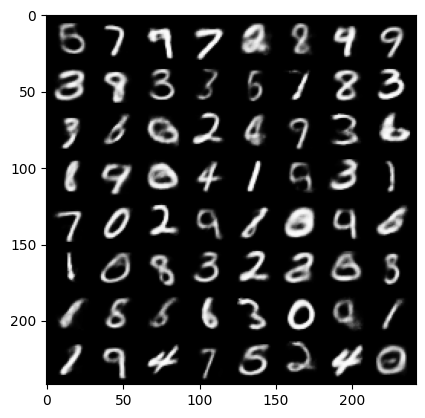

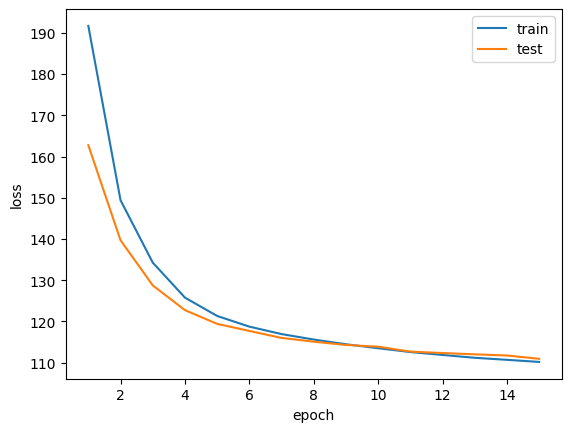

Train Epoch: 16 [0/60000 (0%)]	Loss: 107.959091
Train Epoch: 16 [25600/60000 (43%)]	Loss: 110.574387
Train Epoch: 16 [51200/60000 (85%)]	Loss: 109.317245
====> Epoch: 16 Average loss: 109.7260
====> Test set loss: 110.8374
Train Epoch: 17 [0/60000 (0%)]	Loss: 108.919708
Train Epoch: 17 [25600/60000 (43%)]	Loss: 108.528290
Train Epoch: 17 [51200/60000 (85%)]	Loss: 111.904053
====> Epoch: 17 Average loss: 109.3296
====> Test set loss: 110.7446
Train Epoch: 18 [0/60000 (0%)]	Loss: 104.836258
Train Epoch: 18 [25600/60000 (43%)]	Loss: 113.413811
Train Epoch: 18 [51200/60000 (85%)]	Loss: 108.386002
====> Epoch: 18 Average loss: 108.9763
====> Test set loss: 110.8513
Train Epoch: 19 [0/60000 (0%)]	Loss: 105.963867
Train Epoch: 19 [25600/60000 (43%)]	Loss: 109.494598
Train Epoch: 19 [51200/60000 (85%)]	Loss: 105.889526
====> Epoch: 19 Average loss: 108.6950
====> Test set loss: 110.3694
Train Epoch: 20 [0/60000 (0%)]	Loss: 104.198006
Train Epoch: 20 [25600/60000 (43%)]	Loss: 111.039574
Train E

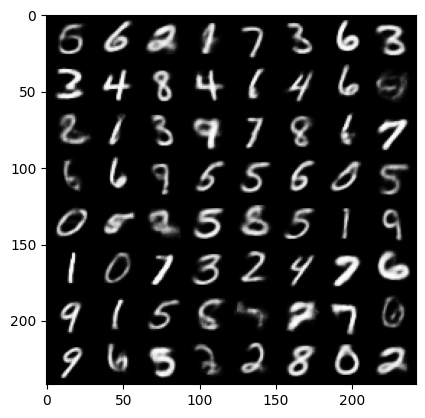

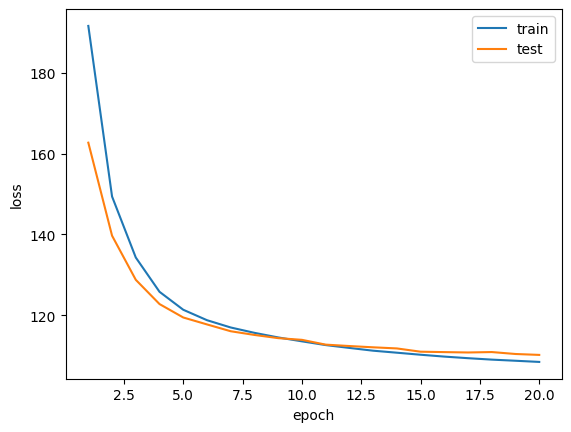

Train Epoch: 21 [0/60000 (0%)]	Loss: 114.580757
Train Epoch: 21 [25600/60000 (43%)]	Loss: 108.046661
Train Epoch: 21 [51200/60000 (85%)]	Loss: 110.220451
====> Epoch: 21 Average loss: 108.1132
====> Test set loss: 109.8477
Train Epoch: 22 [0/60000 (0%)]	Loss: 107.101028
Train Epoch: 22 [25600/60000 (43%)]	Loss: 114.100800
Train Epoch: 22 [51200/60000 (85%)]	Loss: 102.880577
====> Epoch: 22 Average loss: 107.8760
====> Test set loss: 109.8208
Train Epoch: 23 [0/60000 (0%)]	Loss: 106.764915
Train Epoch: 23 [25600/60000 (43%)]	Loss: 105.253754
Train Epoch: 23 [51200/60000 (85%)]	Loss: 110.822487
====> Epoch: 23 Average loss: 107.6173
====> Test set loss: 109.5422
Train Epoch: 24 [0/60000 (0%)]	Loss: 107.599007
Train Epoch: 24 [25600/60000 (43%)]	Loss: 114.458954
Train Epoch: 24 [51200/60000 (85%)]	Loss: 105.035973
====> Epoch: 24 Average loss: 107.4872
====> Test set loss: 109.6712
Train Epoch: 25 [0/60000 (0%)]	Loss: 105.090988
Train Epoch: 25 [25600/60000 (43%)]	Loss: 109.886887
Train E

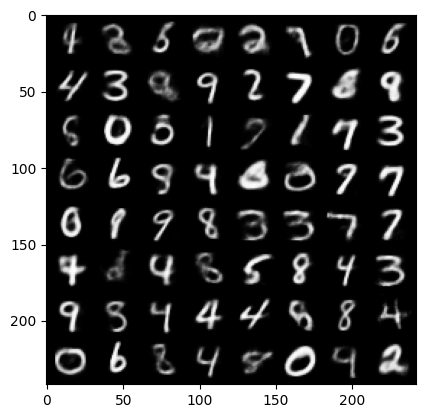

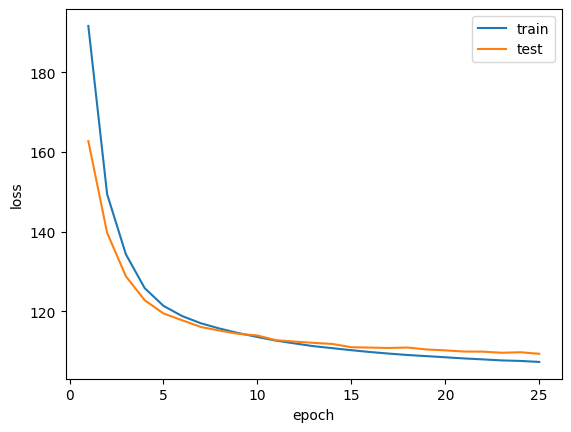

Train Epoch: 26 [0/60000 (0%)]	Loss: 105.035599
Train Epoch: 26 [25600/60000 (43%)]	Loss: 102.904770
Train Epoch: 26 [51200/60000 (85%)]	Loss: 105.231575
====> Epoch: 26 Average loss: 107.0130
====> Test set loss: 109.2366
Train Epoch: 27 [0/60000 (0%)]	Loss: 105.013390
Train Epoch: 27 [25600/60000 (43%)]	Loss: 104.181824
Train Epoch: 27 [51200/60000 (85%)]	Loss: 102.514313
====> Epoch: 27 Average loss: 106.8284
====> Test set loss: 109.3169
Train Epoch: 28 [0/60000 (0%)]	Loss: 104.572571
Train Epoch: 28 [25600/60000 (43%)]	Loss: 104.858490
Train Epoch: 28 [51200/60000 (85%)]	Loss: 107.012512
====> Epoch: 28 Average loss: 106.6523
====> Test set loss: 109.3698
Train Epoch: 29 [0/60000 (0%)]	Loss: 107.978027
Train Epoch: 29 [25600/60000 (43%)]	Loss: 112.506859
Train Epoch: 29 [51200/60000 (85%)]	Loss: 107.165520
====> Epoch: 29 Average loss: 106.4976
====> Test set loss: 109.4532
Train Epoch: 30 [0/60000 (0%)]	Loss: 103.889702
Train Epoch: 30 [25600/60000 (43%)]	Loss: 102.103363
Train E

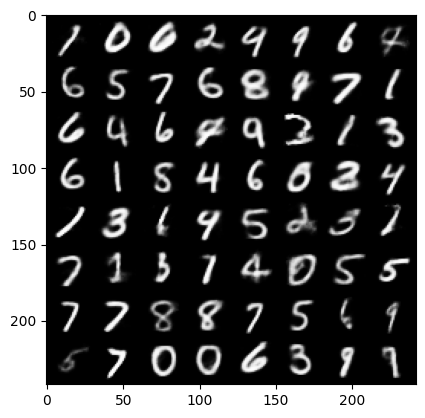

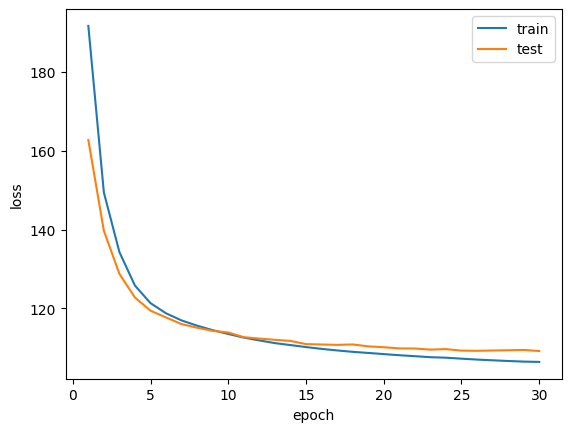

Train Epoch: 31 [0/60000 (0%)]	Loss: 108.140297
Train Epoch: 31 [25600/60000 (43%)]	Loss: 104.390877
Train Epoch: 31 [51200/60000 (85%)]	Loss: 102.693817
====> Epoch: 31 Average loss: 106.1713
====> Test set loss: 108.8679
Train Epoch: 32 [0/60000 (0%)]	Loss: 111.302643
Train Epoch: 32 [25600/60000 (43%)]	Loss: 104.755104
Train Epoch: 32 [51200/60000 (85%)]	Loss: 105.710907
====> Epoch: 32 Average loss: 106.0291
====> Test set loss: 108.8197
Train Epoch: 33 [0/60000 (0%)]	Loss: 102.635628
Train Epoch: 33 [25600/60000 (43%)]	Loss: 110.206360
Train Epoch: 33 [51200/60000 (85%)]	Loss: 100.206047
====> Epoch: 33 Average loss: 105.9402
====> Test set loss: 109.1565
Train Epoch: 34 [0/60000 (0%)]	Loss: 103.102356
Train Epoch: 34 [25600/60000 (43%)]	Loss: 105.022842
Train Epoch: 34 [51200/60000 (85%)]	Loss: 116.020599
====> Epoch: 34 Average loss: 105.8147
====> Test set loss: 109.2049
Train Epoch: 35 [0/60000 (0%)]	Loss: 106.833603
Train Epoch: 35 [25600/60000 (43%)]	Loss: 102.043457
Train E

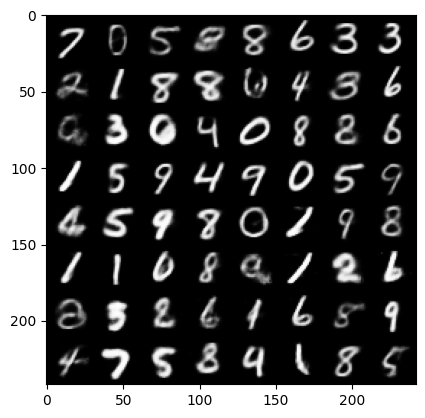

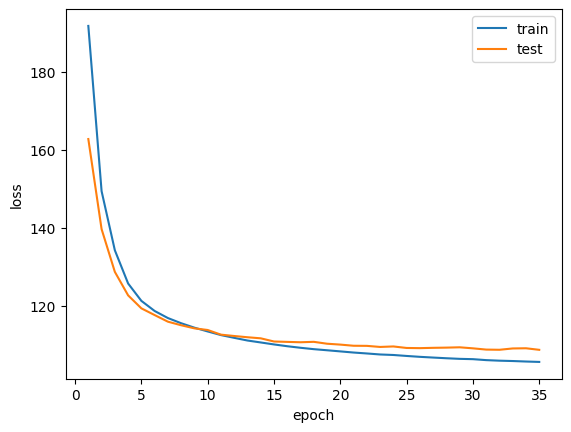

Train Epoch: 36 [0/60000 (0%)]	Loss: 103.505157
Train Epoch: 36 [25600/60000 (43%)]	Loss: 109.978310
Train Epoch: 36 [51200/60000 (85%)]	Loss: 105.951149
====> Epoch: 36 Average loss: 105.5390
====> Test set loss: 108.9226
Train Epoch: 37 [0/60000 (0%)]	Loss: 105.872574
Train Epoch: 37 [25600/60000 (43%)]	Loss: 104.693497
Train Epoch: 37 [51200/60000 (85%)]	Loss: 104.920204
====> Epoch: 37 Average loss: 105.4350
====> Test set loss: 108.9149
Train Epoch: 38 [0/60000 (0%)]	Loss: 105.056129
Train Epoch: 38 [25600/60000 (43%)]	Loss: 106.554909
Train Epoch: 38 [51200/60000 (85%)]	Loss: 98.209396
====> Epoch: 38 Average loss: 105.3258
====> Test set loss: 108.7802
Train Epoch: 39 [0/60000 (0%)]	Loss: 105.987556
Train Epoch: 39 [25600/60000 (43%)]	Loss: 104.814484
Train Epoch: 39 [51200/60000 (85%)]	Loss: 101.305687
====> Epoch: 39 Average loss: 105.2719
====> Test set loss: 108.7581
Train Epoch: 40 [0/60000 (0%)]	Loss: 107.748497
Train Epoch: 40 [25600/60000 (43%)]	Loss: 109.217346
Train Ep

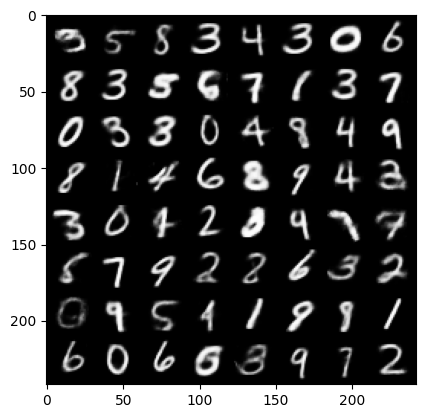

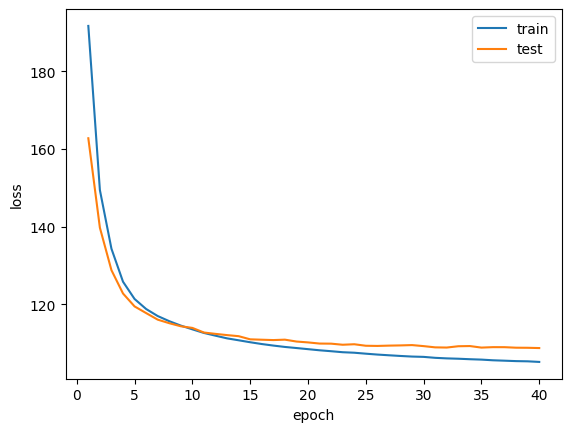

Train Epoch: 41 [0/60000 (0%)]	Loss: 108.549629
Train Epoch: 41 [25600/60000 (43%)]	Loss: 97.765961
Train Epoch: 41 [51200/60000 (85%)]	Loss: 102.592300
====> Epoch: 41 Average loss: 105.0156
====> Test set loss: 108.7515
Train Epoch: 42 [0/60000 (0%)]	Loss: 107.111771
Train Epoch: 42 [25600/60000 (43%)]	Loss: 103.544914
Train Epoch: 42 [51200/60000 (85%)]	Loss: 103.344963
====> Epoch: 42 Average loss: 104.9565
====> Test set loss: 108.7274
Train Epoch: 43 [0/60000 (0%)]	Loss: 104.980812
Train Epoch: 43 [25600/60000 (43%)]	Loss: 112.727394
Train Epoch: 43 [51200/60000 (85%)]	Loss: 102.195084
====> Epoch: 43 Average loss: 104.7878
====> Test set loss: 108.7207
Train Epoch: 44 [0/60000 (0%)]	Loss: 105.223083
Train Epoch: 44 [25600/60000 (43%)]	Loss: 98.297348
Train Epoch: 44 [51200/60000 (85%)]	Loss: 102.050529
====> Epoch: 44 Average loss: 104.7451
====> Test set loss: 108.6407
Train Epoch: 45 [0/60000 (0%)]	Loss: 97.351906
Train Epoch: 45 [25600/60000 (43%)]	Loss: 99.271309
Train Epoch

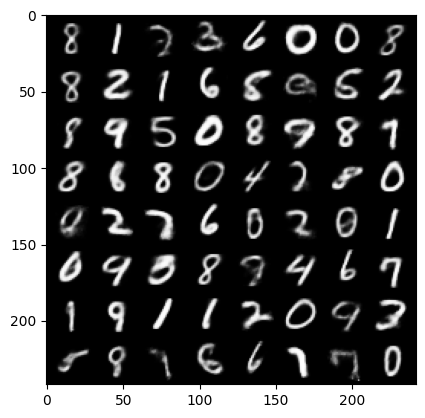

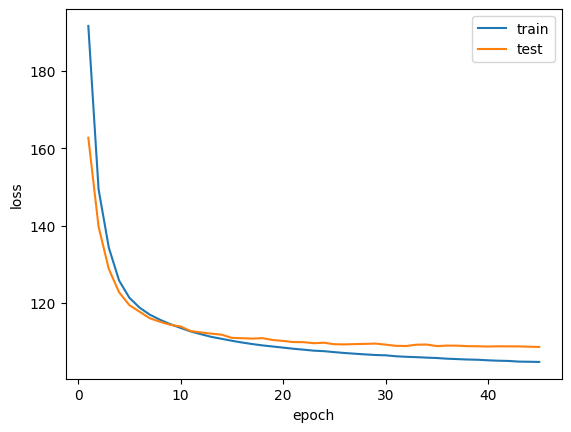

Train Epoch: 46 [0/60000 (0%)]	Loss: 109.002274
Train Epoch: 46 [25600/60000 (43%)]	Loss: 97.726273
Train Epoch: 46 [51200/60000 (85%)]	Loss: 99.118980
====> Epoch: 46 Average loss: 104.5986
====> Test set loss: 108.5803
Train Epoch: 47 [0/60000 (0%)]	Loss: 97.806335
Train Epoch: 47 [25600/60000 (43%)]	Loss: 105.673355
Train Epoch: 47 [51200/60000 (85%)]	Loss: 107.475975
====> Epoch: 47 Average loss: 104.4731
====> Test set loss: 108.5528
Train Epoch: 48 [0/60000 (0%)]	Loss: 105.736786
Train Epoch: 48 [25600/60000 (43%)]	Loss: 100.065048
Train Epoch: 48 [51200/60000 (85%)]	Loss: 107.092133
====> Epoch: 48 Average loss: 104.4199
====> Test set loss: 108.5637
Train Epoch: 49 [0/60000 (0%)]	Loss: 104.155182
Train Epoch: 49 [25600/60000 (43%)]	Loss: 102.855286
Train Epoch: 49 [51200/60000 (85%)]	Loss: 104.172623
====> Epoch: 49 Average loss: 104.3067
====> Test set loss: 108.6968
Train Epoch: 50 [0/60000 (0%)]	Loss: 105.599022
Train Epoch: 50 [25600/60000 (43%)]	Loss: 107.022095
Train Epoc

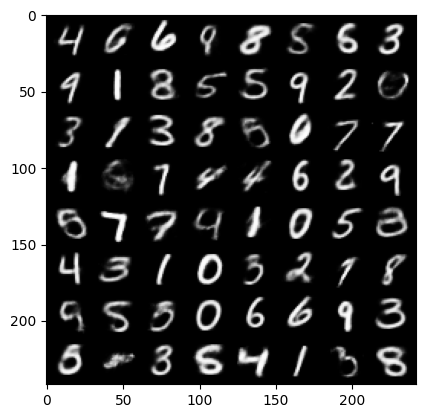

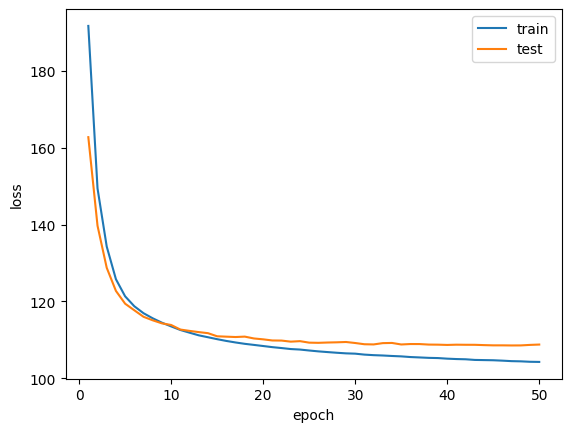

Train Epoch: 51 [0/60000 (0%)]	Loss: 108.267784
Train Epoch: 51 [25600/60000 (43%)]	Loss: 102.932800
Train Epoch: 51 [51200/60000 (85%)]	Loss: 101.935837
====> Epoch: 51 Average loss: 104.2452
====> Test set loss: 108.3933
Train Epoch: 52 [0/60000 (0%)]	Loss: 106.102921
Train Epoch: 52 [25600/60000 (43%)]	Loss: 103.479034
Train Epoch: 52 [51200/60000 (85%)]	Loss: 103.699081
====> Epoch: 52 Average loss: 104.0745
====> Test set loss: 108.5518
Train Epoch: 53 [0/60000 (0%)]	Loss: 106.497726
Train Epoch: 53 [25600/60000 (43%)]	Loss: 102.322441
Train Epoch: 53 [51200/60000 (85%)]	Loss: 108.035538
====> Epoch: 53 Average loss: 104.1022
====> Test set loss: 108.6070
Train Epoch: 54 [0/60000 (0%)]	Loss: 102.282234
Train Epoch: 54 [25600/60000 (43%)]	Loss: 106.914459
Train Epoch: 54 [51200/60000 (85%)]	Loss: 106.915955
====> Epoch: 54 Average loss: 104.0251
====> Test set loss: 108.4209
Train Epoch: 55 [0/60000 (0%)]	Loss: 106.221497
Train Epoch: 55 [25600/60000 (43%)]	Loss: 107.344513
Train E

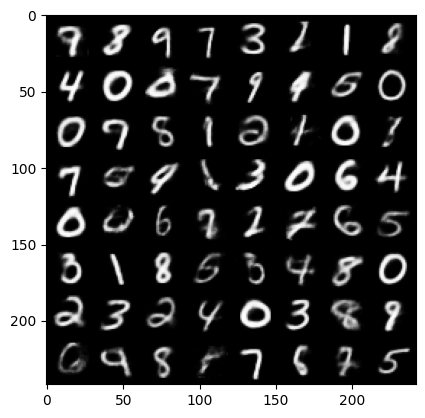

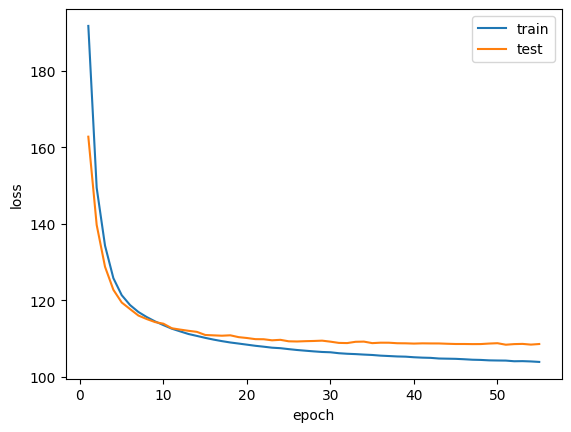

Train Epoch: 56 [0/60000 (0%)]	Loss: 105.419273
Train Epoch: 56 [25600/60000 (43%)]	Loss: 104.707542
Train Epoch: 56 [51200/60000 (85%)]	Loss: 105.528511
====> Epoch: 56 Average loss: 103.8727
====> Test set loss: 108.4522
Train Epoch: 57 [0/60000 (0%)]	Loss: 103.809525
Train Epoch: 57 [25600/60000 (43%)]	Loss: 105.271484
Train Epoch: 57 [51200/60000 (85%)]	Loss: 99.381226
====> Epoch: 57 Average loss: 103.7375
====> Test set loss: 108.5089
Train Epoch: 58 [0/60000 (0%)]	Loss: 102.832123
Train Epoch: 58 [25600/60000 (43%)]	Loss: 100.636040
Train Epoch: 58 [51200/60000 (85%)]	Loss: 104.195984
====> Epoch: 58 Average loss: 103.7850
====> Test set loss: 108.6549
Train Epoch: 59 [0/60000 (0%)]	Loss: 105.223557
Train Epoch: 59 [25600/60000 (43%)]	Loss: 104.793030
Train Epoch: 59 [51200/60000 (85%)]	Loss: 108.223351
====> Epoch: 59 Average loss: 103.6324
====> Test set loss: 108.3144
Train Epoch: 60 [0/60000 (0%)]	Loss: 102.730125
Train Epoch: 60 [25600/60000 (43%)]	Loss: 107.538139
Train Ep

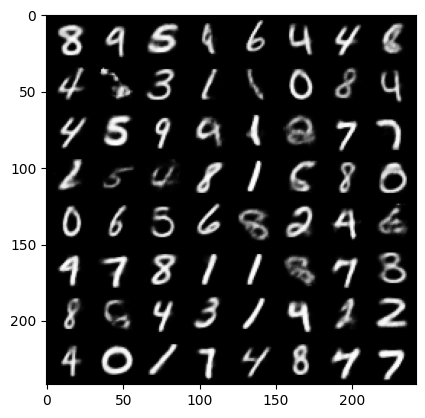

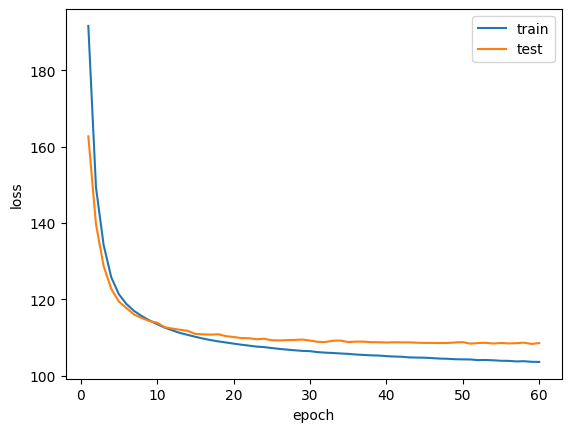

Train Epoch: 61 [0/60000 (0%)]	Loss: 99.904602
Train Epoch: 61 [25600/60000 (43%)]	Loss: 103.550247
Train Epoch: 61 [51200/60000 (85%)]	Loss: 103.442635
====> Epoch: 61 Average loss: 103.5206
====> Test set loss: 108.6159
Train Epoch: 62 [0/60000 (0%)]	Loss: 103.002289
Train Epoch: 62 [25600/60000 (43%)]	Loss: 102.142822
Train Epoch: 62 [51200/60000 (85%)]	Loss: 103.700668
====> Epoch: 62 Average loss: 103.4773
====> Test set loss: 108.7882
Train Epoch: 63 [0/60000 (0%)]	Loss: 102.614059
Train Epoch: 63 [25600/60000 (43%)]	Loss: 104.433990
Train Epoch: 63 [51200/60000 (85%)]	Loss: 101.275620
====> Epoch: 63 Average loss: 103.4767
====> Test set loss: 108.7277
Train Epoch: 64 [0/60000 (0%)]	Loss: 102.732040
Train Epoch: 64 [25600/60000 (43%)]	Loss: 100.669830
Train Epoch: 64 [51200/60000 (85%)]	Loss: 104.074883
====> Epoch: 64 Average loss: 103.3564
====> Test set loss: 108.5675
Train Epoch: 65 [0/60000 (0%)]	Loss: 104.624252
Train Epoch: 65 [25600/60000 (43%)]	Loss: 104.061050
Train Ep

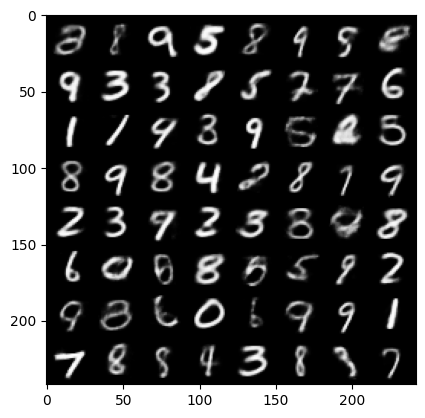

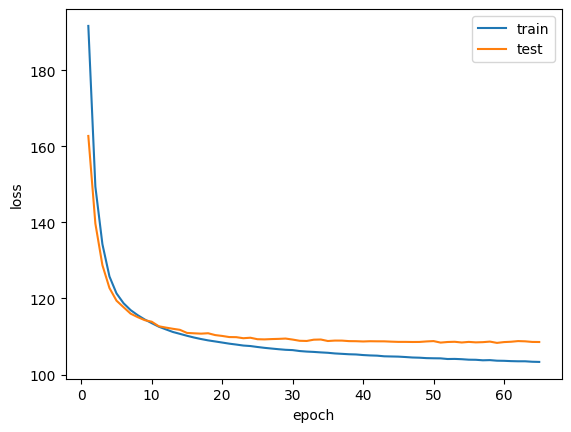

Train Epoch: 66 [0/60000 (0%)]	Loss: 100.422676
Train Epoch: 66 [25600/60000 (43%)]	Loss: 107.166885
Train Epoch: 66 [51200/60000 (85%)]	Loss: 105.313843
====> Epoch: 66 Average loss: 103.2888
====> Test set loss: 108.4197
Train Epoch: 67 [0/60000 (0%)]	Loss: 99.552856
Train Epoch: 67 [25600/60000 (43%)]	Loss: 104.555595
Train Epoch: 67 [51200/60000 (85%)]	Loss: 103.926506
====> Epoch: 67 Average loss: 103.2176
====> Test set loss: 108.7063
Train Epoch: 68 [0/60000 (0%)]	Loss: 101.887108
Train Epoch: 68 [25600/60000 (43%)]	Loss: 102.476311
Train Epoch: 68 [51200/60000 (85%)]	Loss: 103.693428
====> Epoch: 68 Average loss: 103.1718
====> Test set loss: 108.3175
Train Epoch: 69 [0/60000 (0%)]	Loss: 100.775925
Train Epoch: 69 [25600/60000 (43%)]	Loss: 102.473625
Train Epoch: 69 [51200/60000 (85%)]	Loss: 103.622185
====> Epoch: 69 Average loss: 103.0578
====> Test set loss: 108.5266
Train Epoch: 70 [0/60000 (0%)]	Loss: 100.692200
Train Epoch: 70 [25600/60000 (43%)]	Loss: 104.802444
Train Ep

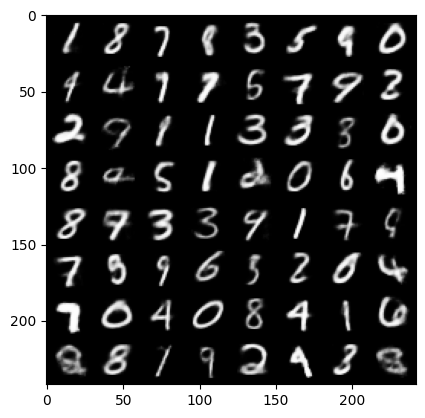

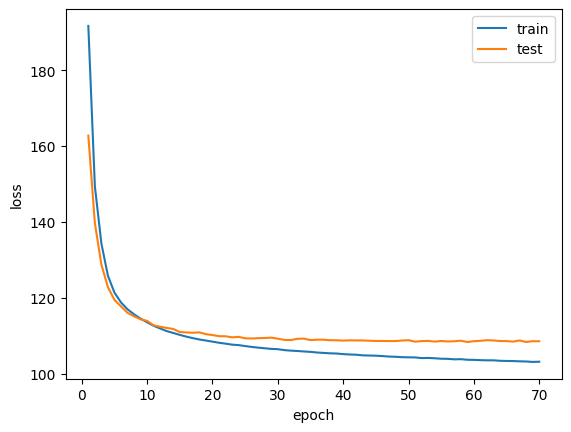

Train Epoch: 71 [0/60000 (0%)]	Loss: 102.261436
Train Epoch: 71 [25600/60000 (43%)]	Loss: 104.708351
Train Epoch: 71 [51200/60000 (85%)]	Loss: 105.195145
====> Epoch: 71 Average loss: 103.0230
====> Test set loss: 108.6236
Train Epoch: 72 [0/60000 (0%)]	Loss: 99.086166
Train Epoch: 72 [25600/60000 (43%)]	Loss: 103.176598
Train Epoch: 72 [51200/60000 (85%)]	Loss: 108.303772
====> Epoch: 72 Average loss: 102.9998
====> Test set loss: 108.4200
Train Epoch: 73 [0/60000 (0%)]	Loss: 102.846893
Train Epoch: 73 [25600/60000 (43%)]	Loss: 101.955627
Train Epoch: 73 [51200/60000 (85%)]	Loss: 104.144600
====> Epoch: 73 Average loss: 102.9265
====> Test set loss: 108.6981
Train Epoch: 74 [0/60000 (0%)]	Loss: 97.563362
Train Epoch: 74 [25600/60000 (43%)]	Loss: 100.681465
Train Epoch: 74 [51200/60000 (85%)]	Loss: 103.015167
====> Epoch: 74 Average loss: 102.8756
====> Test set loss: 108.4755
Train Epoch: 75 [0/60000 (0%)]	Loss: 104.493599
Train Epoch: 75 [25600/60000 (43%)]	Loss: 96.554840
Train Epoc

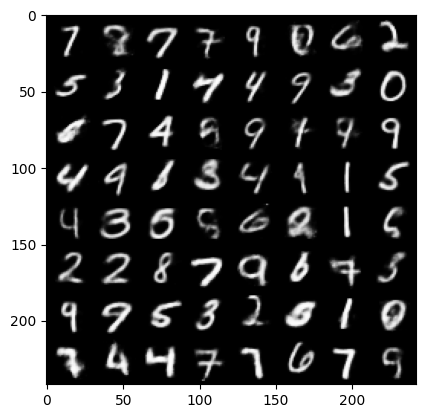

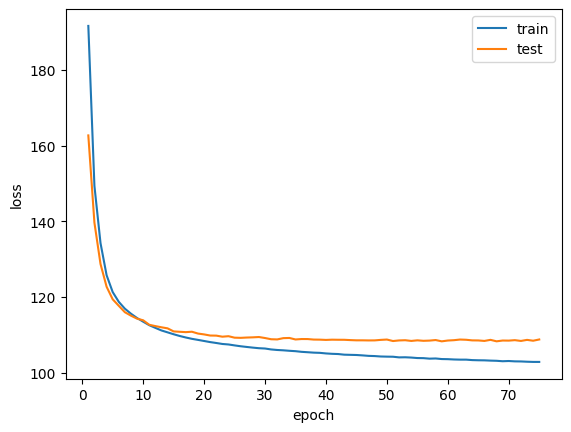

Train Epoch: 76 [0/60000 (0%)]	Loss: 97.013985
Train Epoch: 76 [25600/60000 (43%)]	Loss: 101.422974
Train Epoch: 76 [51200/60000 (85%)]	Loss: 104.919853
====> Epoch: 76 Average loss: 102.8401
====> Test set loss: 108.6886
Train Epoch: 77 [0/60000 (0%)]	Loss: 100.889633
Train Epoch: 77 [25600/60000 (43%)]	Loss: 99.347511
Train Epoch: 77 [51200/60000 (85%)]	Loss: 107.612854
====> Epoch: 77 Average loss: 102.7620
====> Test set loss: 108.7591
Train Epoch: 78 [0/60000 (0%)]	Loss: 101.966454
Train Epoch: 78 [25600/60000 (43%)]	Loss: 96.828812
Train Epoch: 78 [51200/60000 (85%)]	Loss: 103.771858
====> Epoch: 78 Average loss: 102.7541
====> Test set loss: 108.3147
Train Epoch: 79 [0/60000 (0%)]	Loss: 101.609009
Train Epoch: 79 [25600/60000 (43%)]	Loss: 98.547775
Train Epoch: 79 [51200/60000 (85%)]	Loss: 102.613922
====> Epoch: 79 Average loss: 102.6523
====> Test set loss: 108.7273
Train Epoch: 80 [0/60000 (0%)]	Loss: 99.183708
Train Epoch: 80 [25600/60000 (43%)]	Loss: 104.478706
Train Epoch:

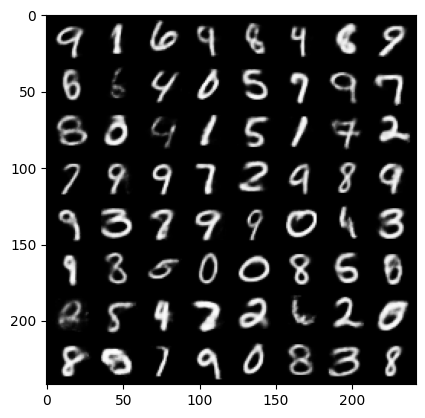

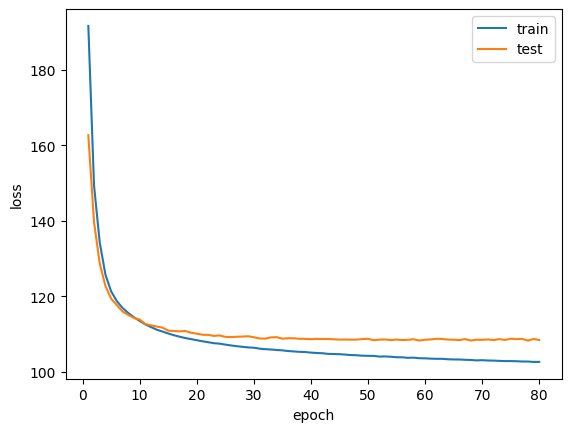

Train Epoch: 81 [0/60000 (0%)]	Loss: 101.462265
Train Epoch: 81 [25600/60000 (43%)]	Loss: 107.704330
Train Epoch: 81 [51200/60000 (85%)]	Loss: 101.257904
====> Epoch: 81 Average loss: 102.5831
====> Test set loss: 108.6265
Train Epoch: 82 [0/60000 (0%)]	Loss: 98.582138
Train Epoch: 82 [25600/60000 (43%)]	Loss: 96.689102
Train Epoch: 82 [51200/60000 (85%)]	Loss: 101.177483
====> Epoch: 82 Average loss: 102.5928
====> Test set loss: 108.6544
Train Epoch: 83 [0/60000 (0%)]	Loss: 100.295639
Train Epoch: 83 [25600/60000 (43%)]	Loss: 101.889496
Train Epoch: 83 [51200/60000 (85%)]	Loss: 97.943550
====> Epoch: 83 Average loss: 102.5019
====> Test set loss: 108.5945
Train Epoch: 84 [0/60000 (0%)]	Loss: 99.848305
Train Epoch: 84 [25600/60000 (43%)]	Loss: 102.148911
Train Epoch: 84 [51200/60000 (85%)]	Loss: 101.406815
====> Epoch: 84 Average loss: 102.4571
====> Test set loss: 108.4878
Train Epoch: 85 [0/60000 (0%)]	Loss: 102.551033
Train Epoch: 85 [25600/60000 (43%)]	Loss: 102.569969
Train Epoch

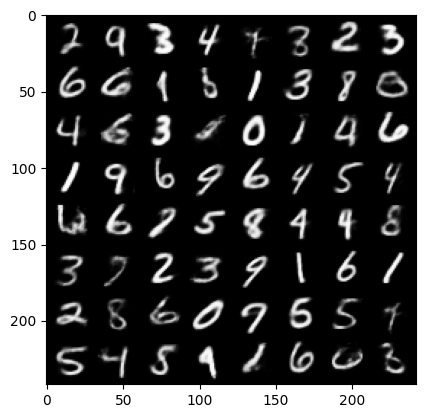

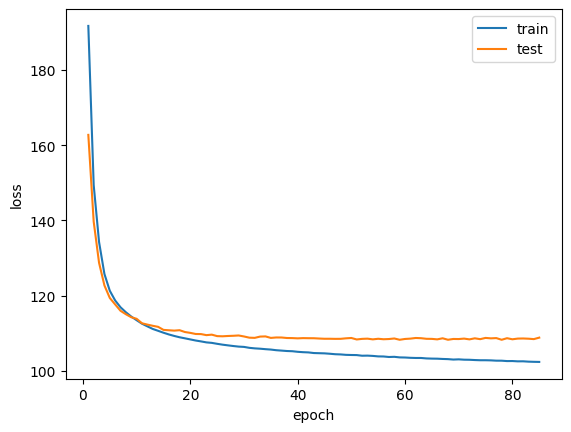

Train Epoch: 86 [0/60000 (0%)]	Loss: 102.072899
Train Epoch: 86 [25600/60000 (43%)]	Loss: 102.819427
Train Epoch: 86 [51200/60000 (85%)]	Loss: 102.349976
====> Epoch: 86 Average loss: 102.3824
====> Test set loss: 108.6782
Train Epoch: 87 [0/60000 (0%)]	Loss: 104.762642
Train Epoch: 87 [25600/60000 (43%)]	Loss: 102.727417
Train Epoch: 87 [51200/60000 (85%)]	Loss: 101.892227
====> Epoch: 87 Average loss: 102.3912
====> Test set loss: 108.5960
Train Epoch: 88 [0/60000 (0%)]	Loss: 101.091591
Train Epoch: 88 [25600/60000 (43%)]	Loss: 99.700638
Train Epoch: 88 [51200/60000 (85%)]	Loss: 102.413750
====> Epoch: 88 Average loss: 102.2884
====> Test set loss: 108.6476
Train Epoch: 89 [0/60000 (0%)]	Loss: 95.263359
Train Epoch: 89 [25600/60000 (43%)]	Loss: 97.501038
Train Epoch: 89 [51200/60000 (85%)]	Loss: 100.475960
====> Epoch: 89 Average loss: 102.2904
====> Test set loss: 108.6828
Train Epoch: 90 [0/60000 (0%)]	Loss: 105.563240
Train Epoch: 90 [25600/60000 (43%)]	Loss: 105.926125
Train Epoc

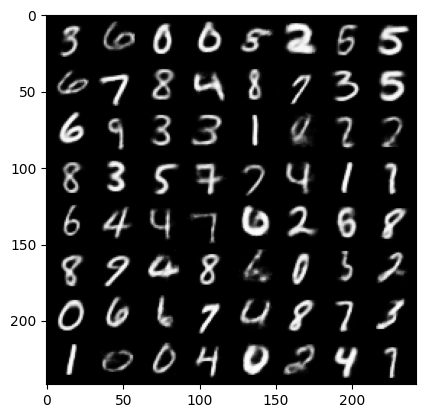

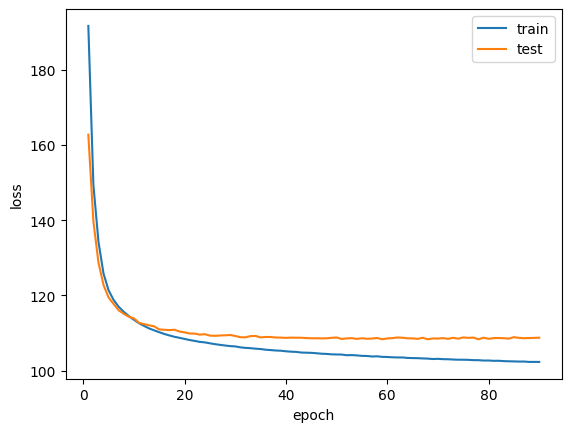

Train Epoch: 91 [0/60000 (0%)]	Loss: 99.795425
Train Epoch: 91 [25600/60000 (43%)]	Loss: 104.588409
Train Epoch: 91 [51200/60000 (85%)]	Loss: 105.506058
====> Epoch: 91 Average loss: 102.1504
====> Test set loss: 108.6545
Train Epoch: 92 [0/60000 (0%)]	Loss: 99.091507
Train Epoch: 92 [25600/60000 (43%)]	Loss: 100.022171
Train Epoch: 92 [51200/60000 (85%)]	Loss: 104.893639
====> Epoch: 92 Average loss: 102.2309
====> Test set loss: 109.3361
Train Epoch: 93 [0/60000 (0%)]	Loss: 97.299065
Train Epoch: 93 [25600/60000 (43%)]	Loss: 101.883972
Train Epoch: 93 [51200/60000 (85%)]	Loss: 100.453690
====> Epoch: 93 Average loss: 102.1348
====> Test set loss: 108.5880
Train Epoch: 94 [0/60000 (0%)]	Loss: 104.303040
Train Epoch: 94 [25600/60000 (43%)]	Loss: 98.823372
Train Epoch: 94 [51200/60000 (85%)]	Loss: 101.291542
====> Epoch: 94 Average loss: 102.1302
====> Test set loss: 108.6258
Train Epoch: 95 [0/60000 (0%)]	Loss: 100.970901
Train Epoch: 95 [25600/60000 (43%)]	Loss: 104.464256
Train Epoch

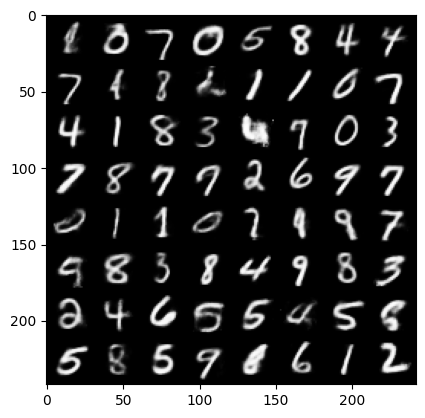

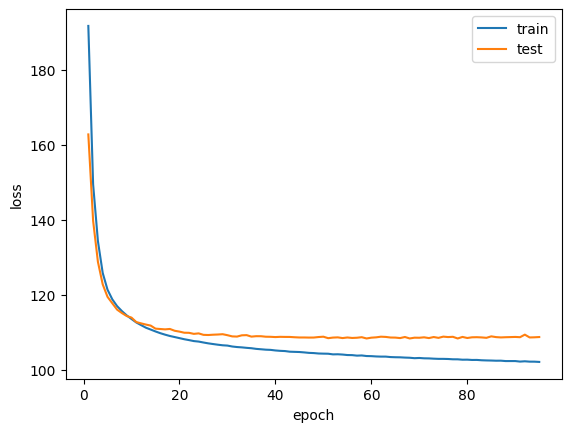

Train Epoch: 96 [0/60000 (0%)]	Loss: 103.051514
Train Epoch: 96 [25600/60000 (43%)]	Loss: 104.465462
Train Epoch: 96 [51200/60000 (85%)]	Loss: 100.548233
====> Epoch: 96 Average loss: 102.0570
====> Test set loss: 108.7537
Train Epoch: 97 [0/60000 (0%)]	Loss: 98.037247
Train Epoch: 97 [25600/60000 (43%)]	Loss: 107.866150
Train Epoch: 97 [51200/60000 (85%)]	Loss: 105.418808
====> Epoch: 97 Average loss: 102.0267
====> Test set loss: 108.6749
Train Epoch: 98 [0/60000 (0%)]	Loss: 104.406052
Train Epoch: 98 [25600/60000 (43%)]	Loss: 99.295547
Train Epoch: 98 [51200/60000 (85%)]	Loss: 96.670929
====> Epoch: 98 Average loss: 101.9787
====> Test set loss: 108.8152
Train Epoch: 99 [0/60000 (0%)]	Loss: 104.788597
Train Epoch: 99 [25600/60000 (43%)]	Loss: 102.059097
Train Epoch: 99 [51200/60000 (85%)]	Loss: 100.084625
====> Epoch: 99 Average loss: 101.9517
====> Test set loss: 108.6905
Train Epoch: 100 [0/60000 (0%)]	Loss: 102.975807
Train Epoch: 100 [25600/60000 (43%)]	Loss: 104.559715
Train Ep

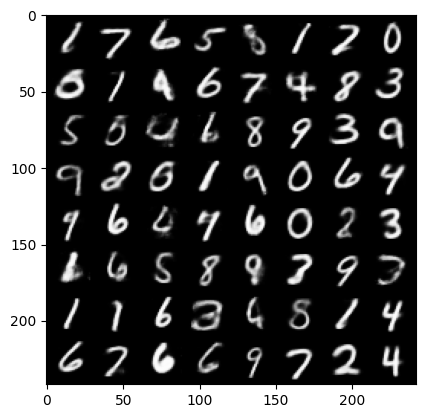

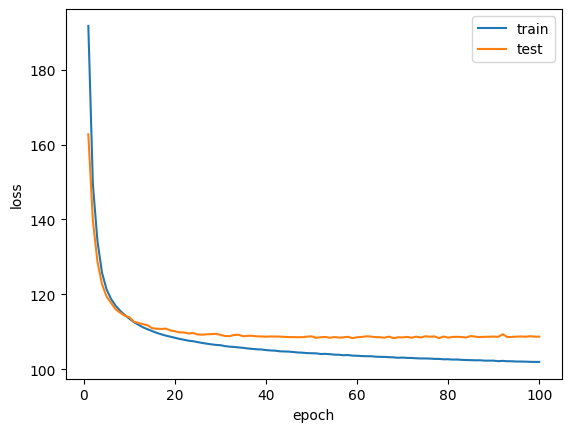

In [61]:
deep_train_loss_list = []
deep_test_loss_list = []
hidden_dim = 20
epochs = 100
deep_model = deepVAE(784, 784).to(device)
optimizer = optim.Adam(deep_model.parameters(), lr=1e-3)

deep_model_ = MODEL(deep_model, optimizer=optimizer)
path = "deep_result/"
if not os.path.exists(path): os.mkdir(path)
for epoch in range(1, epochs+1):
    train_loss = deep_model_.train(epoch, 200)
    test_loss = deep_model_.test(epoch)
    deep_train_loss_list.append(train_loss)
    deep_test_loss_list.append(test_loss)

    with torch.no_grad():
        if epoch % 5 == 0:
            sample = torch.randn(64, hidden_dim).to(device)
            sample = deep_model_.get_model().decode(sample).cpu()
            save_img_name = 'deep_result/sample_'+str(epoch)+'.png'
            save_image(sample.view(64, 1, 28, 28), save_img_name)
            print('*'* 20, f'epoch={epoch}', '*'* 20)
            plt.imshow(img.imread(save_img_name))
            assert len(train_loss_list) == len(test_loss_list)
            plot_loss(deep_train_loss_list, deep_test_loss_list)

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.428101
Train Epoch: 1 [25600/60000 (43%)]	Loss: 200.711182
Train Epoch: 1 [51200/60000 (85%)]	Loss: 175.681686
====> Epoch: 1 Average loss: 202.7818
====> Test set loss: 175.9331
Train Epoch: 2 [0/60000 (0%)]	Loss: 173.611603
Train Epoch: 2 [25600/60000 (43%)]	Loss: 170.858200
Train Epoch: 2 [51200/60000 (85%)]	Loss: 148.545059
====> Epoch: 2 Average loss: 159.9780
====> Test set loss: 147.7436
Train Epoch: 3 [0/60000 (0%)]	Loss: 152.012054
Train Epoch: 3 [25600/60000 (43%)]	Loss: 141.461395
Train Epoch: 3 [51200/60000 (85%)]	Loss: 137.331085
====> Epoch: 3 Average loss: 143.0064
====> Test set loss: 137.1463
Train Epoch: 4 [0/60000 (0%)]	Loss: 138.743713
Train Epoch: 4 [25600/60000 (43%)]	Loss: 132.107422
Train Epoch: 4 [51200/60000 (85%)]	Loss: 131.318069
====> Epoch: 4 Average loss: 133.8465
====> Test set loss: 129.9539
Train Epoch: 5 [0/60000 (0%)]	Loss: 133.104568
Train Epoch: 5 [25600/60000 (43%)]	Loss: 126.302338
Train Epoch: 5 [51200/600

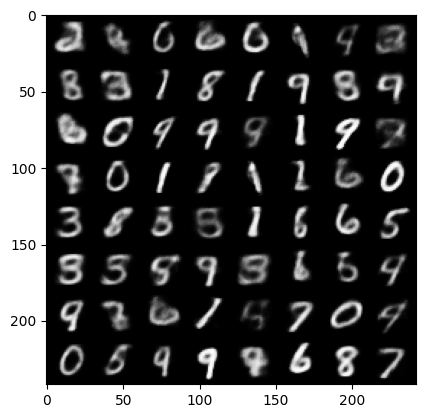

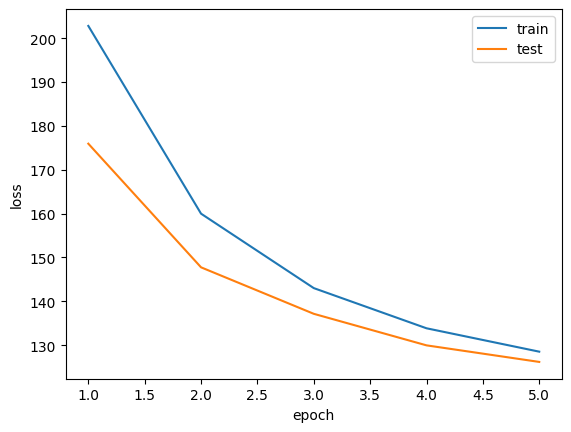

Train Epoch: 6 [0/60000 (0%)]	Loss: 120.640671
Train Epoch: 6 [25600/60000 (43%)]	Loss: 120.372665
Train Epoch: 6 [51200/60000 (85%)]	Loss: 117.842552
====> Epoch: 6 Average loss: 124.9802
====> Test set loss: 123.3155
Train Epoch: 7 [0/60000 (0%)]	Loss: 121.408737
Train Epoch: 7 [25600/60000 (43%)]	Loss: 126.838638
Train Epoch: 7 [51200/60000 (85%)]	Loss: 119.486839
====> Epoch: 7 Average loss: 122.6235
====> Test set loss: 121.1337
Train Epoch: 8 [0/60000 (0%)]	Loss: 120.978760
Train Epoch: 8 [25600/60000 (43%)]	Loss: 123.015076
Train Epoch: 8 [51200/60000 (85%)]	Loss: 116.741325
====> Epoch: 8 Average loss: 120.8717
====> Test set loss: 120.0023
Train Epoch: 9 [0/60000 (0%)]	Loss: 122.487106
Train Epoch: 9 [25600/60000 (43%)]	Loss: 117.104462
Train Epoch: 9 [51200/60000 (85%)]	Loss: 120.612419
====> Epoch: 9 Average loss: 119.5460
====> Test set loss: 118.9319
Train Epoch: 10 [0/60000 (0%)]	Loss: 112.333252
Train Epoch: 10 [25600/60000 (43%)]	Loss: 115.713203
Train Epoch: 10 [51200/

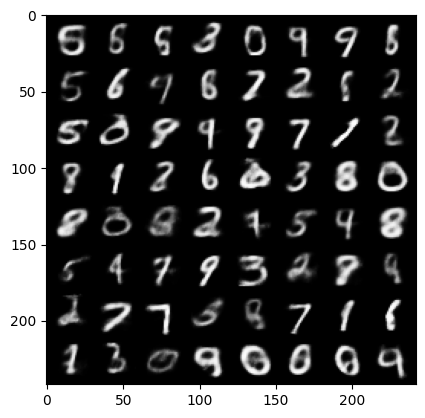

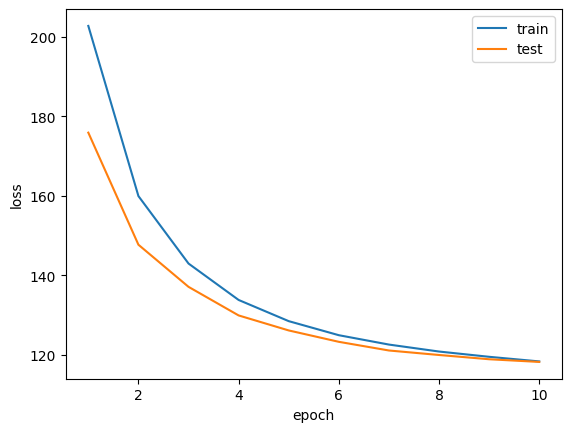

Train Epoch: 11 [0/60000 (0%)]	Loss: 115.366203
Train Epoch: 11 [25600/60000 (43%)]	Loss: 121.115730
Train Epoch: 11 [51200/60000 (85%)]	Loss: 119.938751
====> Epoch: 11 Average loss: 117.4658
====> Test set loss: 117.0786
Train Epoch: 12 [0/60000 (0%)]	Loss: 115.705078
Train Epoch: 12 [25600/60000 (43%)]	Loss: 115.826447
Train Epoch: 12 [51200/60000 (85%)]	Loss: 115.008141
====> Epoch: 12 Average loss: 116.6879
====> Test set loss: 116.6377
Train Epoch: 13 [0/60000 (0%)]	Loss: 119.944824
Train Epoch: 13 [25600/60000 (43%)]	Loss: 112.499054
Train Epoch: 13 [51200/60000 (85%)]	Loss: 112.714790
====> Epoch: 13 Average loss: 116.0603
====> Test set loss: 115.6829
Train Epoch: 14 [0/60000 (0%)]	Loss: 109.009201
Train Epoch: 14 [25600/60000 (43%)]	Loss: 115.245239
Train Epoch: 14 [51200/60000 (85%)]	Loss: 114.761070
====> Epoch: 14 Average loss: 115.4768
====> Test set loss: 115.4050
Train Epoch: 15 [0/60000 (0%)]	Loss: 111.532127
Train Epoch: 15 [25600/60000 (43%)]	Loss: 106.281174
Train E

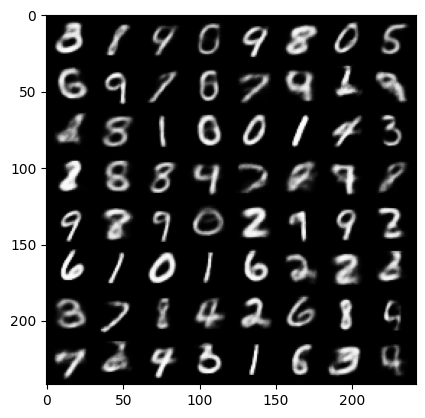

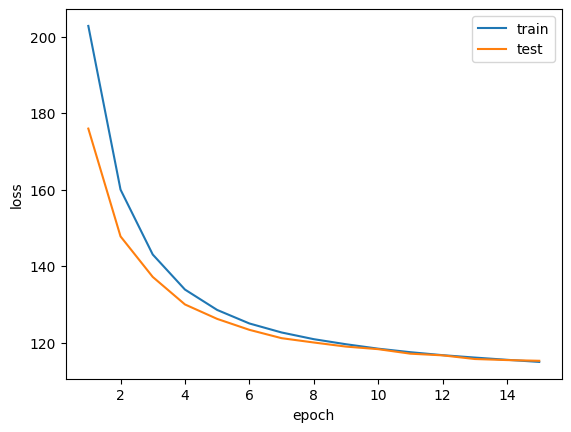

Train Epoch: 16 [0/60000 (0%)]	Loss: 119.464615
Train Epoch: 16 [25600/60000 (43%)]	Loss: 111.478592
Train Epoch: 16 [51200/60000 (85%)]	Loss: 117.632889
====> Epoch: 16 Average loss: 114.5078
====> Test set loss: 114.9877
Train Epoch: 17 [0/60000 (0%)]	Loss: 113.759430
Train Epoch: 17 [25600/60000 (43%)]	Loss: 118.358017
Train Epoch: 17 [51200/60000 (85%)]	Loss: 109.094505
====> Epoch: 17 Average loss: 114.0435
====> Test set loss: 114.3289
Train Epoch: 18 [0/60000 (0%)]	Loss: 111.806786
Train Epoch: 18 [25600/60000 (43%)]	Loss: 111.306564
Train Epoch: 18 [51200/60000 (85%)]	Loss: 112.214249
====> Epoch: 18 Average loss: 113.6549
====> Test set loss: 114.2387
Train Epoch: 19 [0/60000 (0%)]	Loss: 114.942734
Train Epoch: 19 [25600/60000 (43%)]	Loss: 113.947571
Train Epoch: 19 [51200/60000 (85%)]	Loss: 114.651352
====> Epoch: 19 Average loss: 113.3442
====> Test set loss: 113.5453
Train Epoch: 20 [0/60000 (0%)]	Loss: 111.920151
Train Epoch: 20 [25600/60000 (43%)]	Loss: 111.992279
Train E

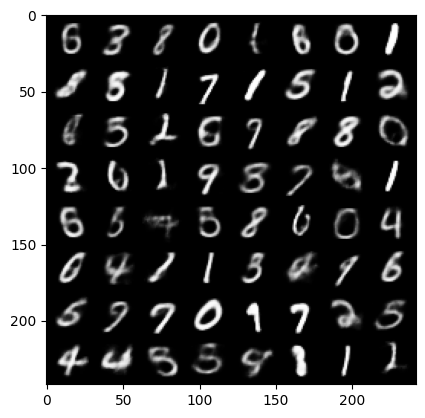

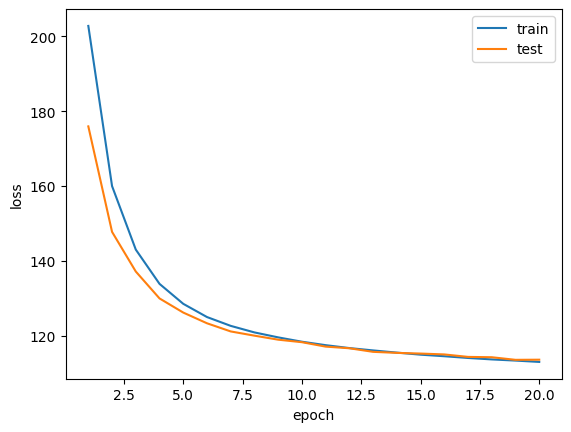

Train Epoch: 21 [0/60000 (0%)]	Loss: 112.673203
Train Epoch: 21 [25600/60000 (43%)]	Loss: 117.464630
Train Epoch: 21 [51200/60000 (85%)]	Loss: 115.080109
====> Epoch: 21 Average loss: 112.6562
====> Test set loss: 113.6122
Train Epoch: 22 [0/60000 (0%)]	Loss: 112.663193
Train Epoch: 22 [25600/60000 (43%)]	Loss: 112.026276
Train Epoch: 22 [51200/60000 (85%)]	Loss: 111.194412
====> Epoch: 22 Average loss: 112.3744
====> Test set loss: 113.2479
Train Epoch: 23 [0/60000 (0%)]	Loss: 115.618050
Train Epoch: 23 [25600/60000 (43%)]	Loss: 114.591927
Train Epoch: 23 [51200/60000 (85%)]	Loss: 116.514137
====> Epoch: 23 Average loss: 112.1628
====> Test set loss: 113.0612
Train Epoch: 24 [0/60000 (0%)]	Loss: 113.053589
Train Epoch: 24 [25600/60000 (43%)]	Loss: 108.945755
Train Epoch: 24 [51200/60000 (85%)]	Loss: 109.758583
====> Epoch: 24 Average loss: 111.8944
====> Test set loss: 112.6010
Train Epoch: 25 [0/60000 (0%)]	Loss: 110.719780
Train Epoch: 25 [25600/60000 (43%)]	Loss: 110.775116
Train E

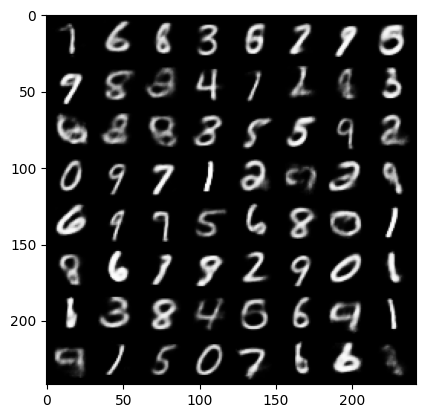

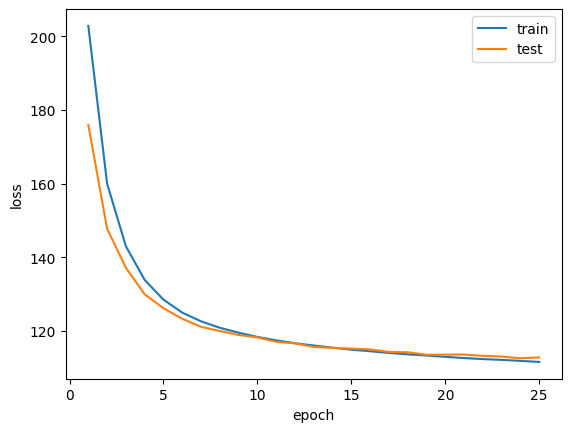

Train Epoch: 26 [0/60000 (0%)]	Loss: 113.790863
Train Epoch: 26 [25600/60000 (43%)]	Loss: 110.313141
Train Epoch: 26 [51200/60000 (85%)]	Loss: 111.297035
====> Epoch: 26 Average loss: 111.4219
====> Test set loss: 112.3408
Train Epoch: 27 [0/60000 (0%)]	Loss: 107.577103
Train Epoch: 27 [25600/60000 (43%)]	Loss: 107.073395
Train Epoch: 27 [51200/60000 (85%)]	Loss: 115.322159
====> Epoch: 27 Average loss: 111.2529
====> Test set loss: 112.5615
Train Epoch: 28 [0/60000 (0%)]	Loss: 109.375809
Train Epoch: 28 [25600/60000 (43%)]	Loss: 110.230690
Train Epoch: 28 [51200/60000 (85%)]	Loss: 112.134979
====> Epoch: 28 Average loss: 111.0256
====> Test set loss: 112.0357
Train Epoch: 29 [0/60000 (0%)]	Loss: 113.501900
Train Epoch: 29 [25600/60000 (43%)]	Loss: 109.171371
Train Epoch: 29 [51200/60000 (85%)]	Loss: 107.898193
====> Epoch: 29 Average loss: 110.7414
====> Test set loss: 111.9873
Train Epoch: 30 [0/60000 (0%)]	Loss: 114.419701
Train Epoch: 30 [25600/60000 (43%)]	Loss: 110.482552
Train E

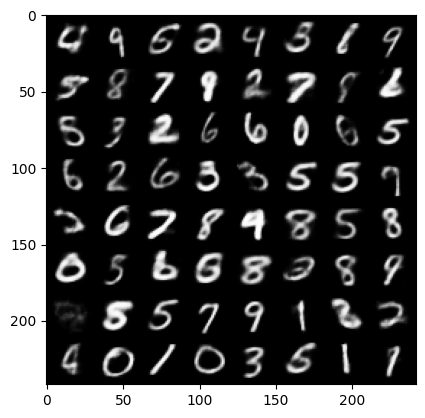

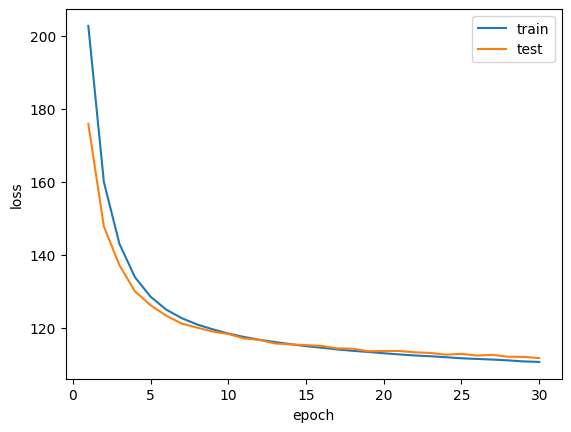

Train Epoch: 31 [0/60000 (0%)]	Loss: 107.940002
Train Epoch: 31 [25600/60000 (43%)]	Loss: 107.634499
Train Epoch: 31 [51200/60000 (85%)]	Loss: 109.207832
====> Epoch: 31 Average loss: 110.4810
====> Test set loss: 111.6904
Train Epoch: 32 [0/60000 (0%)]	Loss: 107.232666
Train Epoch: 32 [25600/60000 (43%)]	Loss: 113.878304
Train Epoch: 32 [51200/60000 (85%)]	Loss: 112.812408
====> Epoch: 32 Average loss: 110.3201
====> Test set loss: 111.8201
Train Epoch: 33 [0/60000 (0%)]	Loss: 103.194321
Train Epoch: 33 [25600/60000 (43%)]	Loss: 111.594666
Train Epoch: 33 [51200/60000 (85%)]	Loss: 109.120506
====> Epoch: 33 Average loss: 110.1820
====> Test set loss: 111.4533
Train Epoch: 34 [0/60000 (0%)]	Loss: 109.253372
Train Epoch: 34 [25600/60000 (43%)]	Loss: 104.396233
Train Epoch: 34 [51200/60000 (85%)]	Loss: 107.536423
====> Epoch: 34 Average loss: 110.0302
====> Test set loss: 111.5667
Train Epoch: 35 [0/60000 (0%)]	Loss: 113.616554
Train Epoch: 35 [25600/60000 (43%)]	Loss: 112.639099
Train E

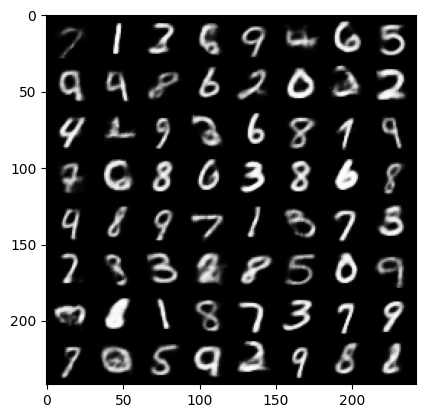

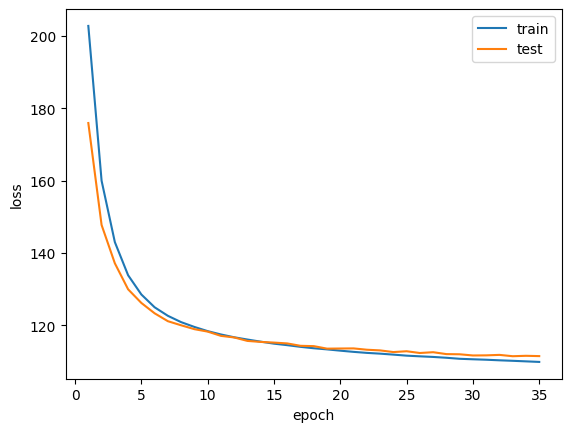

Train Epoch: 36 [0/60000 (0%)]	Loss: 110.818672
Train Epoch: 36 [25600/60000 (43%)]	Loss: 108.498627
Train Epoch: 36 [51200/60000 (85%)]	Loss: 110.589020
====> Epoch: 36 Average loss: 109.7902
====> Test set loss: 111.3877
Train Epoch: 37 [0/60000 (0%)]	Loss: 106.287315
Train Epoch: 37 [25600/60000 (43%)]	Loss: 109.738052
Train Epoch: 37 [51200/60000 (85%)]	Loss: 105.686432
====> Epoch: 37 Average loss: 109.6251
====> Test set loss: 111.3571
Train Epoch: 38 [0/60000 (0%)]	Loss: 111.086548
Train Epoch: 38 [25600/60000 (43%)]	Loss: 114.705688
Train Epoch: 38 [51200/60000 (85%)]	Loss: 110.912666
====> Epoch: 38 Average loss: 109.5349
====> Test set loss: 111.0712
Train Epoch: 39 [0/60000 (0%)]	Loss: 109.607803
Train Epoch: 39 [25600/60000 (43%)]	Loss: 109.738441
Train Epoch: 39 [51200/60000 (85%)]	Loss: 108.245430
====> Epoch: 39 Average loss: 109.3718
====> Test set loss: 111.1921
Train Epoch: 40 [0/60000 (0%)]	Loss: 110.761055
Train Epoch: 40 [25600/60000 (43%)]	Loss: 102.959831
Train E

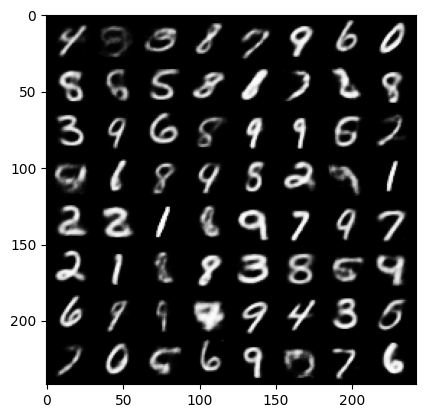

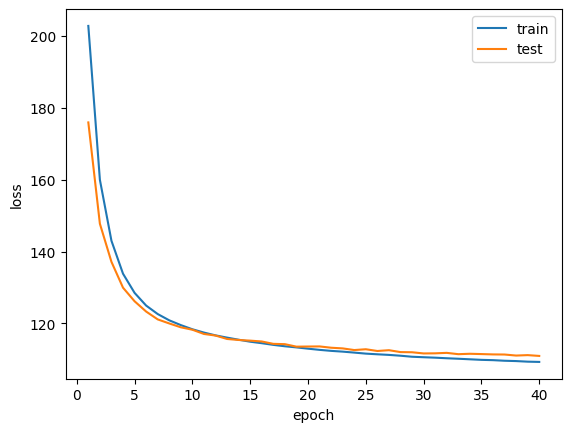

Train Epoch: 41 [0/60000 (0%)]	Loss: 108.444740
Train Epoch: 41 [25600/60000 (43%)]	Loss: 106.719177
Train Epoch: 41 [51200/60000 (85%)]	Loss: 106.921211
====> Epoch: 41 Average loss: 109.2060
====> Test set loss: 110.9270
Train Epoch: 42 [0/60000 (0%)]	Loss: 111.281937
Train Epoch: 42 [25600/60000 (43%)]	Loss: 107.998985
Train Epoch: 42 [51200/60000 (85%)]	Loss: 101.137756
====> Epoch: 42 Average loss: 109.0956
====> Test set loss: 111.1798
Train Epoch: 43 [0/60000 (0%)]	Loss: 109.964180
Train Epoch: 43 [25600/60000 (43%)]	Loss: 109.401115
Train Epoch: 43 [51200/60000 (85%)]	Loss: 111.585876
====> Epoch: 43 Average loss: 109.0224
====> Test set loss: 110.7358
Train Epoch: 44 [0/60000 (0%)]	Loss: 103.653778
Train Epoch: 44 [25600/60000 (43%)]	Loss: 104.815735
Train Epoch: 44 [51200/60000 (85%)]	Loss: 105.244049
====> Epoch: 44 Average loss: 108.8869
====> Test set loss: 110.9734
Train Epoch: 45 [0/60000 (0%)]	Loss: 114.167953
Train Epoch: 45 [25600/60000 (43%)]	Loss: 106.407745
Train E

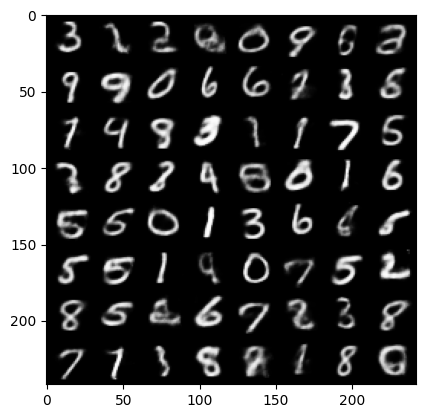

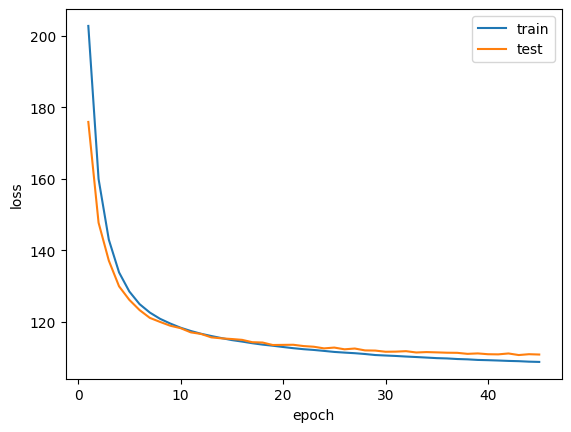

Train Epoch: 46 [0/60000 (0%)]	Loss: 105.986954
Train Epoch: 46 [25600/60000 (43%)]	Loss: 113.973389
Train Epoch: 46 [51200/60000 (85%)]	Loss: 110.181320
====> Epoch: 46 Average loss: 108.7553
====> Test set loss: 110.6147
Train Epoch: 47 [0/60000 (0%)]	Loss: 109.590202
Train Epoch: 47 [25600/60000 (43%)]	Loss: 111.427383
Train Epoch: 47 [51200/60000 (85%)]	Loss: 109.144875
====> Epoch: 47 Average loss: 108.6340
====> Test set loss: 111.0146
Train Epoch: 48 [0/60000 (0%)]	Loss: 105.726944
Train Epoch: 48 [25600/60000 (43%)]	Loss: 103.901825
Train Epoch: 48 [51200/60000 (85%)]	Loss: 109.006729
====> Epoch: 48 Average loss: 108.5670
====> Test set loss: 110.7412
Train Epoch: 49 [0/60000 (0%)]	Loss: 100.835373
Train Epoch: 49 [25600/60000 (43%)]	Loss: 106.729065
Train Epoch: 49 [51200/60000 (85%)]	Loss: 108.663315
====> Epoch: 49 Average loss: 108.4947
====> Test set loss: 110.4624
Train Epoch: 50 [0/60000 (0%)]	Loss: 106.863907
Train Epoch: 50 [25600/60000 (43%)]	Loss: 105.902283
Train E

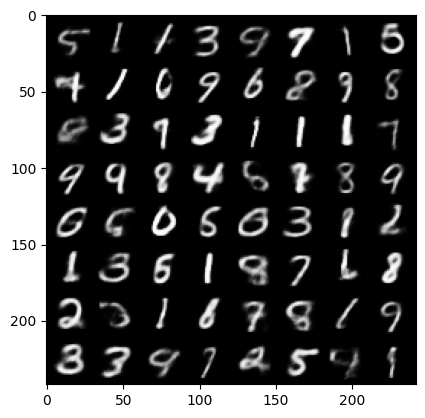

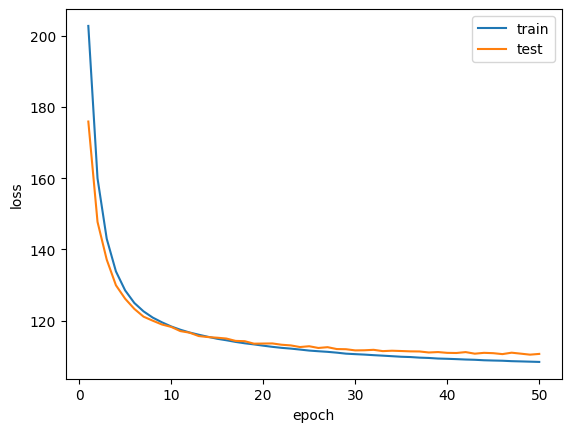

Train Epoch: 51 [0/60000 (0%)]	Loss: 110.544159
Train Epoch: 51 [25600/60000 (43%)]	Loss: 105.502289
Train Epoch: 51 [51200/60000 (85%)]	Loss: 104.638489
====> Epoch: 51 Average loss: 108.3454
====> Test set loss: 110.4154
Train Epoch: 52 [0/60000 (0%)]	Loss: 116.394394
Train Epoch: 52 [25600/60000 (43%)]	Loss: 106.334641
Train Epoch: 52 [51200/60000 (85%)]	Loss: 108.167679
====> Epoch: 52 Average loss: 108.2499
====> Test set loss: 110.7163
Train Epoch: 53 [0/60000 (0%)]	Loss: 111.441849
Train Epoch: 53 [25600/60000 (43%)]	Loss: 107.298553
Train Epoch: 53 [51200/60000 (85%)]	Loss: 108.266762
====> Epoch: 53 Average loss: 108.2056
====> Test set loss: 110.6703
Train Epoch: 54 [0/60000 (0%)]	Loss: 107.003738
Train Epoch: 54 [25600/60000 (43%)]	Loss: 113.422607
Train Epoch: 54 [51200/60000 (85%)]	Loss: 109.843285
====> Epoch: 54 Average loss: 108.1190
====> Test set loss: 110.5357
Train Epoch: 55 [0/60000 (0%)]	Loss: 109.820175
Train Epoch: 55 [25600/60000 (43%)]	Loss: 108.757889
Train E

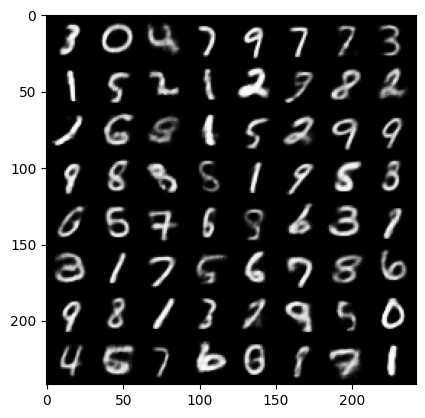

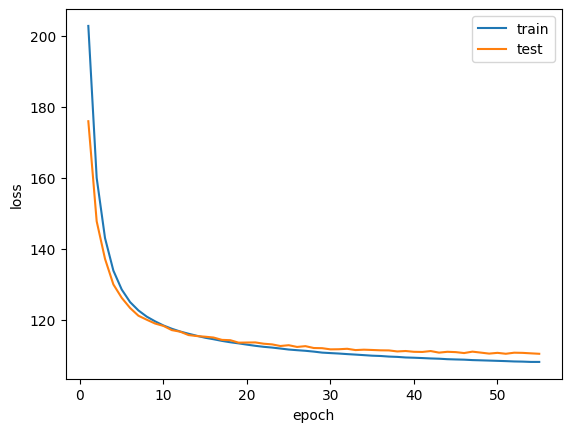

Train Epoch: 56 [0/60000 (0%)]	Loss: 106.418228
Train Epoch: 56 [25600/60000 (43%)]	Loss: 113.044563
Train Epoch: 56 [51200/60000 (85%)]	Loss: 107.440399
====> Epoch: 56 Average loss: 107.9896
====> Test set loss: 110.4982
Train Epoch: 57 [0/60000 (0%)]	Loss: 110.539688
Train Epoch: 57 [25600/60000 (43%)]	Loss: 106.970184
Train Epoch: 57 [51200/60000 (85%)]	Loss: 107.835854
====> Epoch: 57 Average loss: 107.9011
====> Test set loss: 110.6406
Train Epoch: 58 [0/60000 (0%)]	Loss: 108.310074
Train Epoch: 58 [25600/60000 (43%)]	Loss: 110.287987
Train Epoch: 58 [51200/60000 (85%)]	Loss: 107.823410
====> Epoch: 58 Average loss: 107.8687
====> Test set loss: 110.4668
Train Epoch: 59 [0/60000 (0%)]	Loss: 108.397507
Train Epoch: 59 [25600/60000 (43%)]	Loss: 107.960724
Train Epoch: 59 [51200/60000 (85%)]	Loss: 106.825943
====> Epoch: 59 Average loss: 107.8644
====> Test set loss: 110.2821
Train Epoch: 60 [0/60000 (0%)]	Loss: 109.893204
Train Epoch: 60 [25600/60000 (43%)]	Loss: 107.167488
Train E

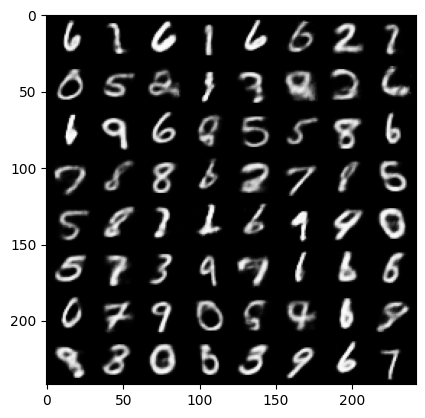

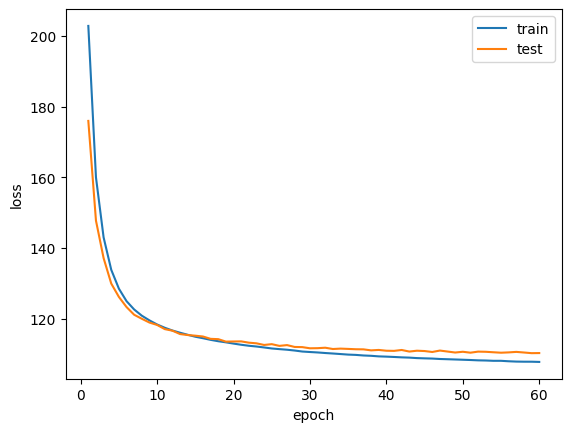

Train Epoch: 61 [0/60000 (0%)]	Loss: 101.997658
Train Epoch: 61 [25600/60000 (43%)]	Loss: 109.615997
Train Epoch: 61 [51200/60000 (85%)]	Loss: 106.891411
====> Epoch: 61 Average loss: 107.6668
====> Test set loss: 110.6105
Train Epoch: 62 [0/60000 (0%)]	Loss: 102.347473
Train Epoch: 62 [25600/60000 (43%)]	Loss: 107.967232
Train Epoch: 62 [51200/60000 (85%)]	Loss: 105.633217
====> Epoch: 62 Average loss: 107.6759
====> Test set loss: 110.3557
Train Epoch: 63 [0/60000 (0%)]	Loss: 103.027077
Train Epoch: 63 [25600/60000 (43%)]	Loss: 107.666016
Train Epoch: 63 [51200/60000 (85%)]	Loss: 109.347198
====> Epoch: 63 Average loss: 107.6049
====> Test set loss: 110.2957
Train Epoch: 64 [0/60000 (0%)]	Loss: 110.525711
Train Epoch: 64 [25600/60000 (43%)]	Loss: 108.156784
Train Epoch: 64 [51200/60000 (85%)]	Loss: 110.691368
====> Epoch: 64 Average loss: 107.5887
====> Test set loss: 110.3061
Train Epoch: 65 [0/60000 (0%)]	Loss: 107.199524
Train Epoch: 65 [25600/60000 (43%)]	Loss: 109.277603
Train E

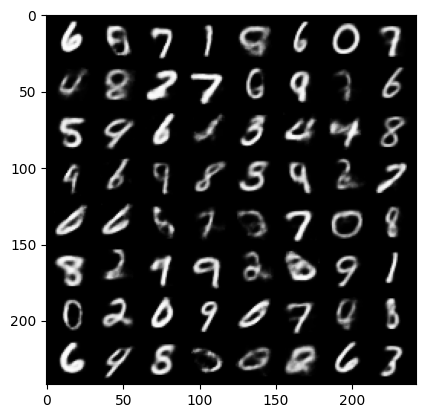

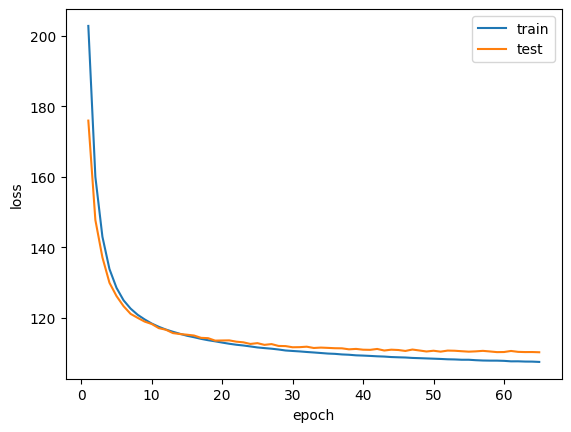

Train Epoch: 66 [0/60000 (0%)]	Loss: 100.204918
Train Epoch: 66 [25600/60000 (43%)]	Loss: 104.778488
Train Epoch: 66 [51200/60000 (85%)]	Loss: 104.327225
====> Epoch: 66 Average loss: 107.4717
====> Test set loss: 109.9950
Train Epoch: 67 [0/60000 (0%)]	Loss: 109.787903
Train Epoch: 67 [25600/60000 (43%)]	Loss: 112.238388
Train Epoch: 67 [51200/60000 (85%)]	Loss: 106.442719
====> Epoch: 67 Average loss: 107.4256
====> Test set loss: 110.1074
Train Epoch: 68 [0/60000 (0%)]	Loss: 105.036415
Train Epoch: 68 [25600/60000 (43%)]	Loss: 111.015625
Train Epoch: 68 [51200/60000 (85%)]	Loss: 109.136909
====> Epoch: 68 Average loss: 107.3309
====> Test set loss: 110.0127
Train Epoch: 69 [0/60000 (0%)]	Loss: 108.516190
Train Epoch: 69 [25600/60000 (43%)]	Loss: 110.777962
Train Epoch: 69 [51200/60000 (85%)]	Loss: 106.917793
====> Epoch: 69 Average loss: 107.3046
====> Test set loss: 109.9932
Train Epoch: 70 [0/60000 (0%)]	Loss: 108.187042
Train Epoch: 70 [25600/60000 (43%)]	Loss: 111.244049
Train E

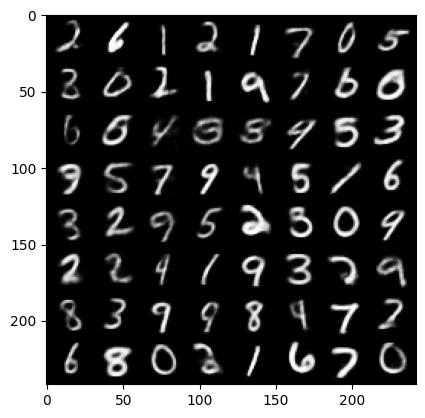

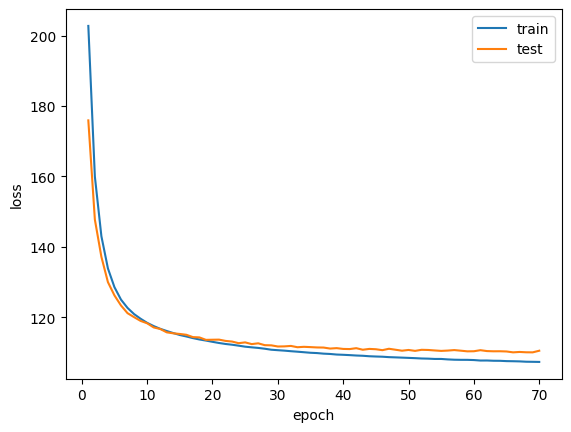

Train Epoch: 71 [0/60000 (0%)]	Loss: 109.187057
Train Epoch: 71 [25600/60000 (43%)]	Loss: 105.402794
Train Epoch: 71 [51200/60000 (85%)]	Loss: 110.217560
====> Epoch: 71 Average loss: 107.2334
====> Test set loss: 110.0130
Train Epoch: 72 [0/60000 (0%)]	Loss: 107.943222
Train Epoch: 72 [25600/60000 (43%)]	Loss: 105.696625
Train Epoch: 72 [51200/60000 (85%)]	Loss: 106.268944
====> Epoch: 72 Average loss: 107.1897
====> Test set loss: 109.9341
Train Epoch: 73 [0/60000 (0%)]	Loss: 107.981873
Train Epoch: 73 [25600/60000 (43%)]	Loss: 108.343414
Train Epoch: 73 [51200/60000 (85%)]	Loss: 109.480751
====> Epoch: 73 Average loss: 107.1513
====> Test set loss: 109.9846
Train Epoch: 74 [0/60000 (0%)]	Loss: 104.395035
Train Epoch: 74 [25600/60000 (43%)]	Loss: 104.856377
Train Epoch: 74 [51200/60000 (85%)]	Loss: 111.609337
====> Epoch: 74 Average loss: 107.0783
====> Test set loss: 110.0715
Train Epoch: 75 [0/60000 (0%)]	Loss: 107.742577
Train Epoch: 75 [25600/60000 (43%)]	Loss: 106.506577
Train E

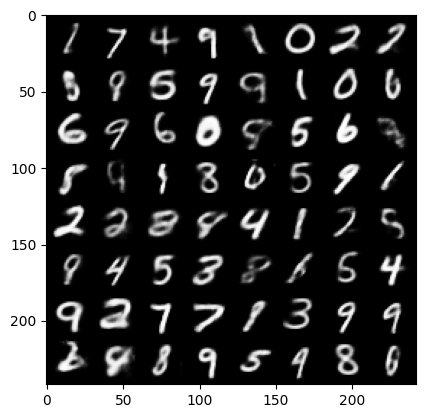

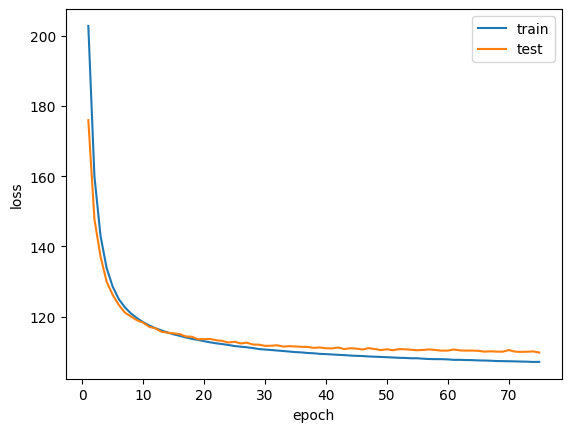

Train Epoch: 76 [0/60000 (0%)]	Loss: 106.245850
Train Epoch: 76 [25600/60000 (43%)]	Loss: 103.039413
Train Epoch: 76 [51200/60000 (85%)]	Loss: 110.803452
====> Epoch: 76 Average loss: 106.9819
====> Test set loss: 110.0025
Train Epoch: 77 [0/60000 (0%)]	Loss: 104.152100
Train Epoch: 77 [25600/60000 (43%)]	Loss: 107.338692
Train Epoch: 77 [51200/60000 (85%)]	Loss: 108.673714
====> Epoch: 77 Average loss: 107.0025
====> Test set loss: 110.0116
Train Epoch: 78 [0/60000 (0%)]	Loss: 111.608582
Train Epoch: 78 [25600/60000 (43%)]	Loss: 108.005814
Train Epoch: 78 [51200/60000 (85%)]	Loss: 110.726532
====> Epoch: 78 Average loss: 106.9487
====> Test set loss: 109.7438
Train Epoch: 79 [0/60000 (0%)]	Loss: 106.578255
Train Epoch: 79 [25600/60000 (43%)]	Loss: 109.822624
Train Epoch: 79 [51200/60000 (85%)]	Loss: 106.727455
====> Epoch: 79 Average loss: 106.8861
====> Test set loss: 109.9132
Train Epoch: 80 [0/60000 (0%)]	Loss: 108.761559
Train Epoch: 80 [25600/60000 (43%)]	Loss: 110.225960
Train E

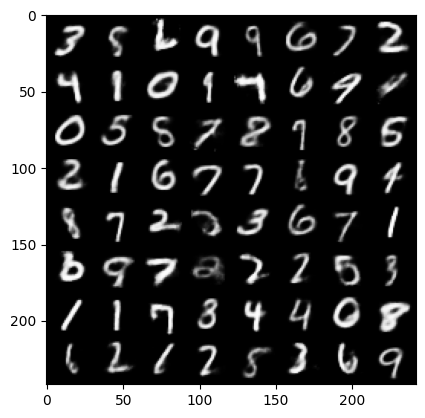

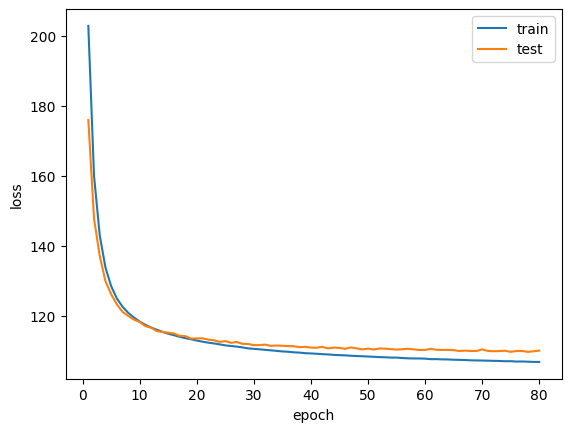

Train Epoch: 81 [0/60000 (0%)]	Loss: 107.158394
Train Epoch: 81 [25600/60000 (43%)]	Loss: 110.135201
Train Epoch: 81 [51200/60000 (85%)]	Loss: 109.419991
====> Epoch: 81 Average loss: 106.8500
====> Test set loss: 110.0879
Train Epoch: 82 [0/60000 (0%)]	Loss: 107.377098
Train Epoch: 82 [25600/60000 (43%)]	Loss: 109.822647
Train Epoch: 82 [51200/60000 (85%)]	Loss: 107.137405
====> Epoch: 82 Average loss: 106.7922
====> Test set loss: 109.8549
Train Epoch: 83 [0/60000 (0%)]	Loss: 103.055328
Train Epoch: 83 [25600/60000 (43%)]	Loss: 111.651146
Train Epoch: 83 [51200/60000 (85%)]	Loss: 107.350677
====> Epoch: 83 Average loss: 106.7476
====> Test set loss: 109.6954
Train Epoch: 84 [0/60000 (0%)]	Loss: 101.659149
Train Epoch: 84 [25600/60000 (43%)]	Loss: 106.267761
Train Epoch: 84 [51200/60000 (85%)]	Loss: 106.352135
====> Epoch: 84 Average loss: 106.7440
====> Test set loss: 109.7690
Train Epoch: 85 [0/60000 (0%)]	Loss: 110.947365
Train Epoch: 85 [25600/60000 (43%)]	Loss: 106.049530
Train E

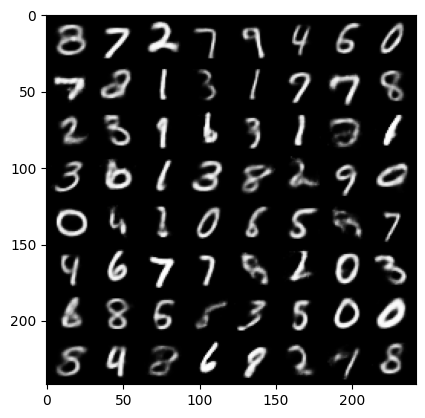

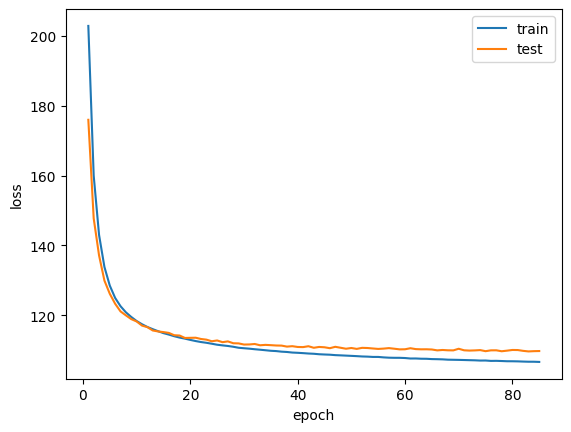

Train Epoch: 86 [0/60000 (0%)]	Loss: 105.714127
Train Epoch: 86 [25600/60000 (43%)]	Loss: 104.077751
Train Epoch: 86 [51200/60000 (85%)]	Loss: 109.450951
====> Epoch: 86 Average loss: 106.6136
====> Test set loss: 109.8408
Train Epoch: 87 [0/60000 (0%)]	Loss: 107.524406
Train Epoch: 87 [25600/60000 (43%)]	Loss: 109.562576
Train Epoch: 87 [51200/60000 (85%)]	Loss: 108.581108
====> Epoch: 87 Average loss: 106.6438
====> Test set loss: 109.9193
Train Epoch: 88 [0/60000 (0%)]	Loss: 111.825531
Train Epoch: 88 [25600/60000 (43%)]	Loss: 109.130486
Train Epoch: 88 [51200/60000 (85%)]	Loss: 103.250381
====> Epoch: 88 Average loss: 106.6185
====> Test set loss: 109.7647
Train Epoch: 89 [0/60000 (0%)]	Loss: 107.988068
Train Epoch: 89 [25600/60000 (43%)]	Loss: 105.678673
Train Epoch: 89 [51200/60000 (85%)]	Loss: 104.944290
====> Epoch: 89 Average loss: 106.5676
====> Test set loss: 110.1583
Train Epoch: 90 [0/60000 (0%)]	Loss: 102.004616
Train Epoch: 90 [25600/60000 (43%)]	Loss: 105.003738
Train E

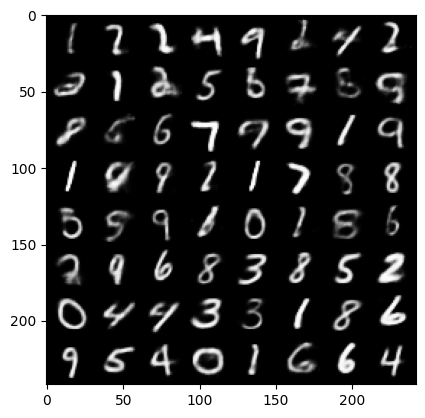

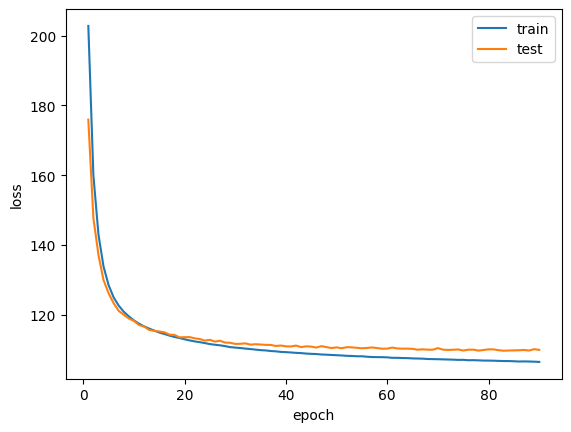

Train Epoch: 91 [0/60000 (0%)]	Loss: 107.277336
Train Epoch: 91 [25600/60000 (43%)]	Loss: 107.394608
Train Epoch: 91 [51200/60000 (85%)]	Loss: 109.767700
====> Epoch: 91 Average loss: 106.5272
====> Test set loss: 109.9423
Train Epoch: 92 [0/60000 (0%)]	Loss: 103.514198
Train Epoch: 92 [25600/60000 (43%)]	Loss: 105.251686
Train Epoch: 92 [51200/60000 (85%)]	Loss: 109.605080
====> Epoch: 92 Average loss: 106.4695
====> Test set loss: 109.9375
Train Epoch: 93 [0/60000 (0%)]	Loss: 107.150429
Train Epoch: 93 [25600/60000 (43%)]	Loss: 99.926437
Train Epoch: 93 [51200/60000 (85%)]	Loss: 106.770493
====> Epoch: 93 Average loss: 106.4064
====> Test set loss: 109.9850
Train Epoch: 94 [0/60000 (0%)]	Loss: 107.273323
Train Epoch: 94 [25600/60000 (43%)]	Loss: 106.752716
Train Epoch: 94 [51200/60000 (85%)]	Loss: 105.561707
====> Epoch: 94 Average loss: 106.4503
====> Test set loss: 109.6961
Train Epoch: 95 [0/60000 (0%)]	Loss: 105.773521
Train Epoch: 95 [25600/60000 (43%)]	Loss: 104.384834
Train Ep

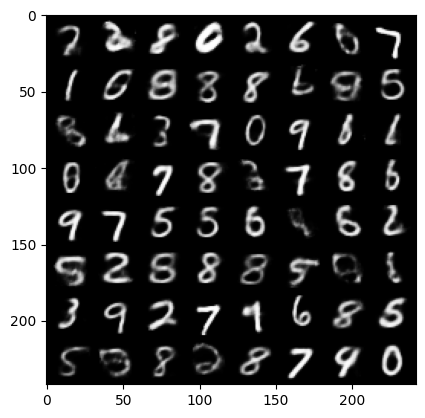

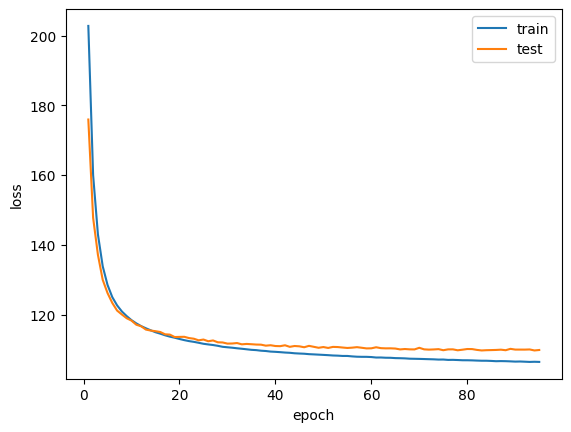

Train Epoch: 96 [0/60000 (0%)]	Loss: 102.858139
Train Epoch: 96 [25600/60000 (43%)]	Loss: 103.110001
Train Epoch: 96 [51200/60000 (85%)]	Loss: 107.862595
====> Epoch: 96 Average loss: 106.3679
====> Test set loss: 109.8385
Train Epoch: 97 [0/60000 (0%)]	Loss: 102.808975
Train Epoch: 97 [25600/60000 (43%)]	Loss: 102.820206
Train Epoch: 97 [51200/60000 (85%)]	Loss: 106.224876
====> Epoch: 97 Average loss: 106.3556
====> Test set loss: 109.9073
Train Epoch: 98 [0/60000 (0%)]	Loss: 110.649330
Train Epoch: 98 [25600/60000 (43%)]	Loss: 105.347656
Train Epoch: 98 [51200/60000 (85%)]	Loss: 105.297241
====> Epoch: 98 Average loss: 106.2849
====> Test set loss: 110.1205
Train Epoch: 99 [0/60000 (0%)]	Loss: 102.333008
Train Epoch: 99 [25600/60000 (43%)]	Loss: 104.812408
Train Epoch: 99 [51200/60000 (85%)]	Loss: 104.121925
====> Epoch: 99 Average loss: 106.2572
====> Test set loss: 109.7220
Train Epoch: 100 [0/60000 (0%)]	Loss: 105.528320
Train Epoch: 100 [25600/60000 (43%)]	Loss: 112.085892
Train

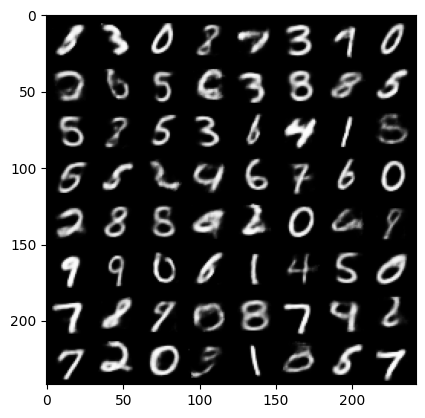

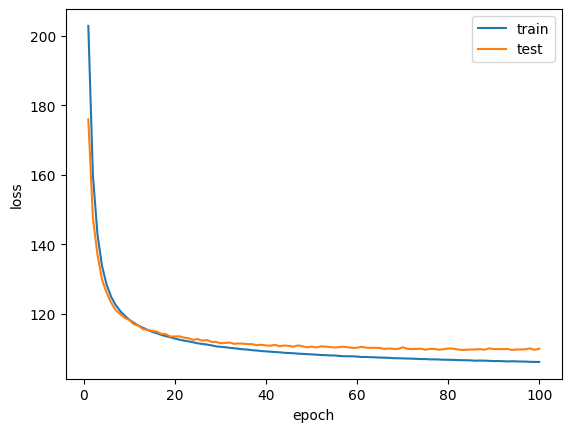

In [64]:
deep_train_loss_list_1 = []
deep_test_loss_list_1 = []
hidden_dim = 20
epochs = 100
deep_model_1 = deepVAE(784, 784, hid_1=256, hid_2=128, hid_3=64).to(device)
optimizer = optim.Adam(deep_model_1.parameters(), lr=1e-3)

deep_model_v = MODEL(deep_model_1, optimizer=optimizer)
path = "deep_result_1/"
if not os.path.exists(path): os.mkdir(path)
for epoch in range(1, epochs+1):
    train_loss = deep_model_v.train(epoch, 200)
    test_loss = deep_model_v.test(epoch)
    deep_train_loss_list_1.append(train_loss)
    deep_test_loss_list_1.append(test_loss)

    with torch.no_grad():
        if epoch % 5 == 0:
            sample = torch.randn(64, hidden_dim).to(device)
            sample = deep_model_v.get_model().decode(sample).cpu()
            save_img_name = path+'sample_'+str(epoch)+'.png'
            save_image(sample.view(64, 1, 28, 28), save_img_name)
            print('*'* 20, f'epoch={epoch}', '*'* 20)
            plt.imshow(img.imread(save_img_name))
            plot_loss(deep_train_loss_list_1, deep_test_loss_list_1)

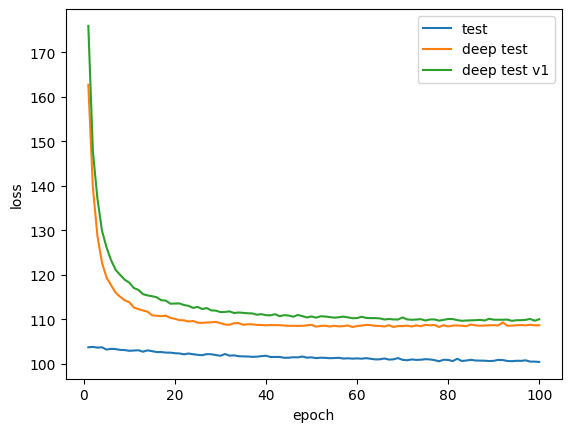

In [66]:
l = len(deep_train_loss_list)
plt.figure()
# plt.plot(range(1, l+1), train_loss_list, label = "train")
plt.plot(range(1, l+1), test_loss_list, label = "test")
# plt.plot(range(1, l+1), deep_train_loss_list, label = "deep train")
plt.plot(range(1, l+1), deep_test_loss_list, label = "deep test")
# plt.plot(range(1, l+1), deep_train_loss_list_1, label = "deep train v1")
plt.plot(range(1, l+1), deep_test_loss_list_1, label = "deep test v1")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

  Preparing metadata (setup.py) ... done


In [9]:
torch.randn_like(std) * std

tensor([ 0.4520, -0.0126])

In [11]:
a = torch.randn_like(std)

In [12]:
a

tensor([-1.7202, -2.6255])

In [13]:
std

tensor([0.3000, 0.1000])

In [14]:
a * std

tensor([-0.5161, -0.2625])

In [15]:
a[0] * std[0]

tensor(-0.5161)

In [45]:
x = arange(5)
y = np.exp(5)
plt.figure(0)
plt.plot(x, y)

z = np.sin(x)
plt.figure(1)
plt.plot(x, z)

w = np.cos(x)
plt.figure(0) # Here's the part I need
plt.plot(x, w)

NameError: ignored